# Introduction #

# Imports #

## Libraries ##

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import nltk
from time import time
from wordcloud import WordCloud
import re
from varname import argname2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import TSNE
from matplotlib.ticker import NullFormatter
import matplotlib.colors as mcolors
import matplotlib as mpl
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [299]:
def sentence_vectorizer(sentence, model):
    sent_vect = []
    numw = 0
    for word in sentence:
        try:
            if numw == 0:
                sent_vect = model.wv[word]
            else:
                sent_vect = np.add(sent_vect, model.wv[word])
            numw += 1
        except:
            pass
    return np.asarray(sent_vect) / numw

def create_W2V_X(model):
    X = []
    for index, description in data_df['description'].iteritems():
        X.append(sentence_vectorizer(description, model))
    X = np.asarray(X)
    return X

def show_loss_acc(model_history, name):
    fig, ax = plt.subplots(1, 2, figsize=(24,12))
    ax[0].set_title('Loss', fontsize=12)
    ax[0].plot(model_history.history['loss'], label='train')
    ax[0].plot(model_history.history['val_loss'], label='test')
    ax[0].legend(fontsize=8)
    ax[1].set_title('Accuracy', fontsize=12)
    ax[1].plot(model_history.history['accuracy'], label='train')
    ax[1].plot(model_history.history['val_accuracy'], label='test')
    ax[1].legend(fontsize=8)
    plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Loss_Acc_{}.png'.format(name))
    
def create_confusion_matrix(labels_test, labels_preds, labels_true, classifier_name):
    lbl_to_plot = set(labels_true)
    lenght = len(lbl_to_plot)
    if lenght == len(set(labels_1)):
        lvl_nb = 1
    elif lenght == len(set(labels_2)):
        lvl_nb = 2
    else :
        lvl_nb = 3
    conf_mat = confusion_matrix(labels_test, labels_preds)
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
                xticklabels=lbl_to_plot, 
                yticklabels=lbl_to_plot)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("CONFUSION MATRIX - {} Classifier on the Categories of Level {}\n"
              .format(classifier_name), size=16)
    plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix {} Level {}.png'
               .format(classifier_name, lvl_nb))
    
def tsne_transformation(X, name):
    t0 = time()
    X_tsne = tsne.fit_transform(X)
    t1 = time()
    tsne_time = t1-t0
    print('Time elapsed for the {} method: {} s.'.format(name, tsne_time))
    return X_tsne

def visualize_tsne(X_method, labels, method_name, labels_lvl):
    fig, ax = plt.subplots(figsize = (24,12))
    color_palette = [mcolors.CSS4_COLORS[i] for i in mcolors.CSS4_COLORS]
    ax.set_prop_cycle(color=color_palette[::-5])

    groups = pd.DataFrame(X_method, columns=['x', 'y']).assign(category=labels).groupby('category')
    for name, points in groups:
        ax.scatter(points.x, points.y, label=name)

    ax.set_title('Visual Distribution of Categories')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    ax.legend(bbox_to_anchor=(0.9,0), ncol=7)

    plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Text tSNE {} for Categoreis of Level {}.png'
                .format(method_name, labels_lvl))
    plt.show()
    
def train_test_separation(X, y):
    encoder = OneHotEncoder(handle_unknown='ignore')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state = 0)
    y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
    y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
    set_dict = {'X_train' : X_train, 
                'X_test' : X_test,
                'y_train' : y_train,
                'y_test' : y_test,
                'y_train_encoded' : y_train_encoded,
                'y_test_encoded' : y_test_encoded}
    return set_dict

def classic_classifier(classifier, method_set, classifier_name, labels):
    # We train the classifier
    t0 = time()
    classifier.fit(method_set['X_train'], method_set['y_train'])

    # We try to predict the test set
    classifier_y_pred = classifier.predict(method_set['X_test'])
    t1 = time()
    classifier_time = t1-t0

    # We evaluate the accuracy of the model
    classifier_accuracy = metrics.accuracy_score(method_set['y_test'], classifier_y_pred)*100
    print('Our Naive Bayes Classifier has an accuracy of : {:.2f}% in {:.2f}s.'
          .format(classifier_accuracy, classifier_time))

    # We create a confusion matrix to see where are the most problematic categories
    create_confusion_matrix(method_set['y_test'], classifier_y_pred, labels, classifier_name)

# Creating some variables that will be usefull for later
def find_all_words(dataframe, dataframe_serie_name):
    list_name = []
    for i in range(len(dataframe)):
        temp_list = dataframe.loc[i, dataframe_serie_name]
        for k in range(len(temp_list)):
            list_name.append(temp_list[k])
    list_name.sort()
    return list_name

# Creating a function to create a dataframe with the Bag of Words (BoW) for a given category
def create_BoW_dataframe(category):
    t0 = time()
    df = pd.DataFrame(columns=['words'])
    df['words'] = np.unique(np.array(all_words))
    cat_list = list(data_df[category].unique())
    for cat in cat_list:
        temp_df = data_df[data_df[category]==cat]
        temp_df.reset_index(inplace=True)
        cat_words = find_all_words(temp_df, 'description')
        word_counter = {}
        for word in cat_words:
            if word not in word_counter.keys():
                word_counter[word] = 1
            else:
                word_counter[word] += 1
        for key in word_counter:
            key_index = list(df[df['words']==key].index)[0]
            df.loc[key_index, cat] = word_counter[key]
    t1 = time()
    index_to_delete = []
    regex = re.compile("^\d+$")
    for i ,j in df['words'].iteritems():
        if len(j) == 1:
            index_to_delete.append(i)
        elif regex.match(j):
            index_to_delete.append(i)
    df.drop(index_to_delete, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print('Time needed for {} is {} seconds.'.format(category, t1-t0))
    return df

# Create a function to show wordcloud of dataframe
def create_WC_from_DF(*dataframe):
    name = argname2('*dataframe')
    for name, dataframe in zip(name, dataframe):
        dataframe.__dfname__ = name
    t0 = time()
    col_list = list(dataframe.columns)
    col_list.pop(0)
    # Finding the right size for the subplot
    total_dimension = len(col_list)
    sqrt = np.sqrt(total_dimension)
    test_dim = total_dimension/int(sqrt)
    if test_dim == int(test_dim):
        dim_1, dim_2 = int(sqrt), int(test_dim)
    else:
        dim_1, dim_2 = int(sqrt), int(test_dim+1)
    fig, ax = plt.subplots(dim_1, dim_2, figsize = (dim_1*6,dim_2*6))
    # Going through the columns to create wordclouds
    for i in range(len(col_list)):
        # Wordcloud creation
        text_list = []
        for j, k in category_1_df['Home Furnishing'].iteritems():
            if np.isnan(k) not in [True]:
                word = category_1_df.loc[j, 'words']
                word_list = [word]*int(k)
                text_list.extend(word_list)
        text = ' '.join(text_list)
        wordcloud = WordCloud(width=800, height=800).generate(text)
        # Wordcloud plotting
        l = i%dim_1
        m = i%dim_2
        ax[l,m].imshow(wordcloud)
        ax[l,m].set_title('Category {}:'.format(col_list[i]),
                          fontsize = 12, fontweight = 'bold')
    t1 = time()
    print('Time elapsed : {} s.\n'.format(t1-t0))
    plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'WordCloud_{}.png'.format(dataframe.__dfname__))
    plt.show()

## Data ##

### Data Selection ###

We will only retain the features that will interest us.

In [2]:
# Reading the csv file
data_df = pd.read_csv('Ressources' + '/' + 'flipkart_com-ecommerce_sample_1050.csv', 
                      usecols=['uniq_id', 'product_category_tree', 'image', 'description'])

# First look of the database
data_df

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                  product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >>...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
...                                                 ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                            description  
0     Key Features of Elegance Polyester Multicolor ...  
1     Specifications of Sathiyas Cotton Bath Towel (...  
2     Key Features of Eurospa Cotton Terry Face Towe...  
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  
4     Key Features of Jaipur Print Cotton Floral Kin...  
...                                                 ...  
1045  Oren Empower Extra Large Self Adhesive Sticker...  
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...  

[1050 rows x 4 columns]

### Data Treatment ###

We will explore, rearrange and clean very quickly the data. We will do further cleaning later on. 

The first thing we will do is separate the differents categories of product to help with the later classification.

In [3]:
# String manipulations to separate the different categories of product
for i in range(len(data_df)):
    data_df.loc[i, 'product_category_tree'] = data_df.loc[i, 'product_category_tree'].replace('"]' , '')
    data_df.loc[i, 'product_category_tree']= data_df.loc[i, 'product_category_tree'].replace('["' , '')
    category_list = data_df.loc[i, 'product_category_tree'].split(' >> ')
    for j in range(len(category_list)):
        if j+1 == len(category_list):
            data_df.loc[i, 'product_name'] = category_list[j]
        else:
            data_df.loc[i, 'category {}'.format(j+1)] = category_list[j]

# Reordering the columns
data_df = data_df[['uniq_id', 'product_name', 'description', 'image', 
                   'category 1', 'category 2', 'category 3', 'category 4', 
                   'category 5', 'category 6']]
data_df = data_df.rename(columns={'uniq_id':'id', 'product_name':'name'})
data_df

id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                                   name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1     Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...   
2     Eurospa Cotton Terry Face Towel Set (20 PIECE ...   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045                              Oren Empower Stickers   
1046                                Wallmantra Stickers   
1047                                  Uberlyfe Stickers   
1048                                Wallmantra Stickers   
1049                                  Uberlyfe Stickers   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                     image       category 1  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   
...                                    ...              ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care   
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care   
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care   

                  category 2        category 3  \
0     Curtains & Accessories          Curtains   
1           Baby Bath & Skin  Baby Bath Towels   
2           Baby Bath & Skin  Baby Bath Towels   
3                  Bed Linen         Bedsheets   
4                  Bed Linen         Bedsheets   
...                      ...               ...   
1045       Baby & Kids Gifts          Stickers   
1046       Baby & Kids Gifts          Stickers   
1047       Baby & Kids Gifts          Stickers   
1048       Baby & Kids Gifts          Stickers   
1049       Baby & Kids Gifts          Stickers   

                           category 4 category 5 category 6  
0                                 NaN        NaN        NaN  
1           Sathiyas Baby Bath Towels        NaN        NaN  
2            Eurospa Baby Bath Towels        NaN        NaN  
3     SANTOSH ROYAL FASHION Bedsheets        NaN        NaN  
4              Jaipur Print Bedsheets        NaN        NaN  
...                               ...        ...        ...  
1045                              NaN        NaN        NaN  
1046                              NaN        NaN        NaN  
1047                              NaN        NaN        NaN  
1048                              NaN        NaN        NaN  
1049                              NaN        NaN        NaN  

[1050 rows

We will now look if there is any missing information.

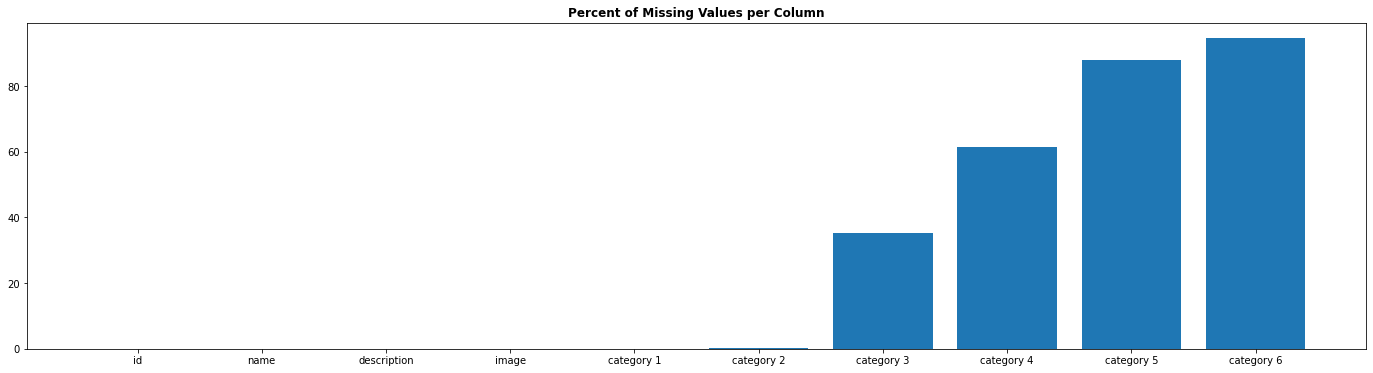

In [4]:
# Preparation pour le graphe
missing_df = data_df.isna().sum().to_frame()
missing_df = missing_df/len(data_df)*100
missing_df.columns = ['Count']

# Graphe 
fig, ax = plt.subplots(1, 1, figsize=(24,6))

# Missing Data
ax.bar(missing_df.index, missing_df['Count'])
ax.set_title('Percent of Missing Values per Column', fontsize=12, fontweight='bold')
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Missing Values.png')

We can see that there is no missing information. We can also see that the products mostly have 2 to 3 categories.

Next we will count the unique values of each column.

In [5]:
# Printing the unique values of each column
print('The total number of products in the database is {}.\n\n'.format(len(data_df)))
for col in data_df.columns:
    print('The column {} has {} unique values.'.format(col, data_df[col].nunique()))

The total number of products in the database is 1050.


The column id has 1050 unique values.
The column name has 642 unique values.
The column description has 1050 unique values.
The column image has 1050 unique values.
The column category 1 has 7 unique values.
The column category 2 has 61 unique values.
The column category 3 has 143 unique values.
The column category 4 has 161 unique values.
The column category 5 has 76 unique values.
The column category 6 has 47 unique values.


We can see that we have no duplicates in the unique ID, image and description of each row. However, some products seems to have the same name. It might be a same product with different colors for example.

Between the missing values and the unique values increase, we can safely assume that being able to classify up until the third category of product should be enough information for most product. We will then only keep the three main category of products.

In [6]:
# Getting rid of the column without much information
data_df = data_df.drop(columns=['category 4','category 5','category 6'])
print('The new database has {} rows and {} columns.'.format(data_df.shape[0], data_df.shape[1]))

The new database has 1050 rows and 7 columns.


We will replace the NaN values in the categories by a new category called 'Unknown'.

In [7]:
replace_list = ['category 2', 'category 3']
for col in replace_list:
    data_df[col].replace(np.nan, 'Unknown', inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1050 non-null   object
 1   name         1050 non-null   object
 2   description  1050 non-null   object
 3   image        1050 non-null   object
 4   category 1   1050 non-null   object
 5   category 2   1050 non-null   object
 6   category 3   1050 non-null   object
dtypes: object(7)
memory usage: 57.5+ KB


We will look at how many products there are in each category.

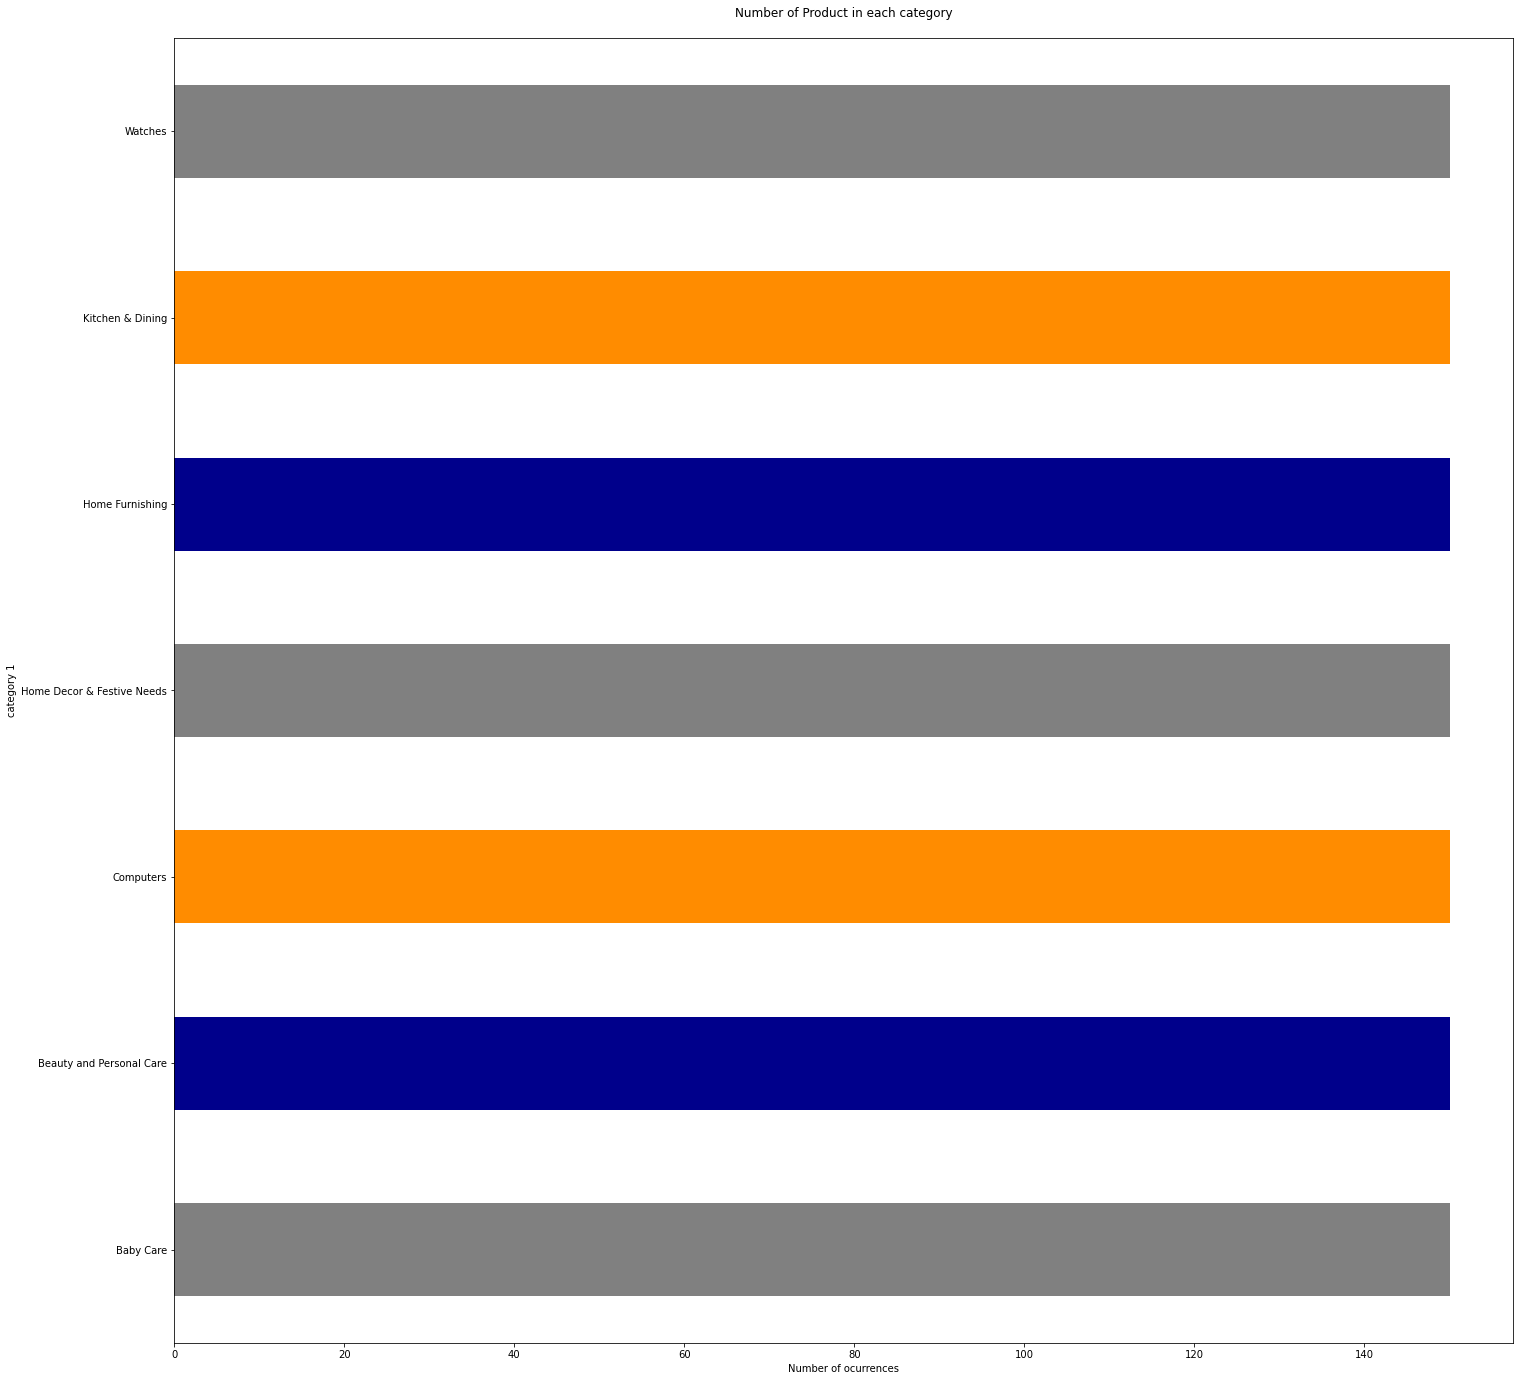

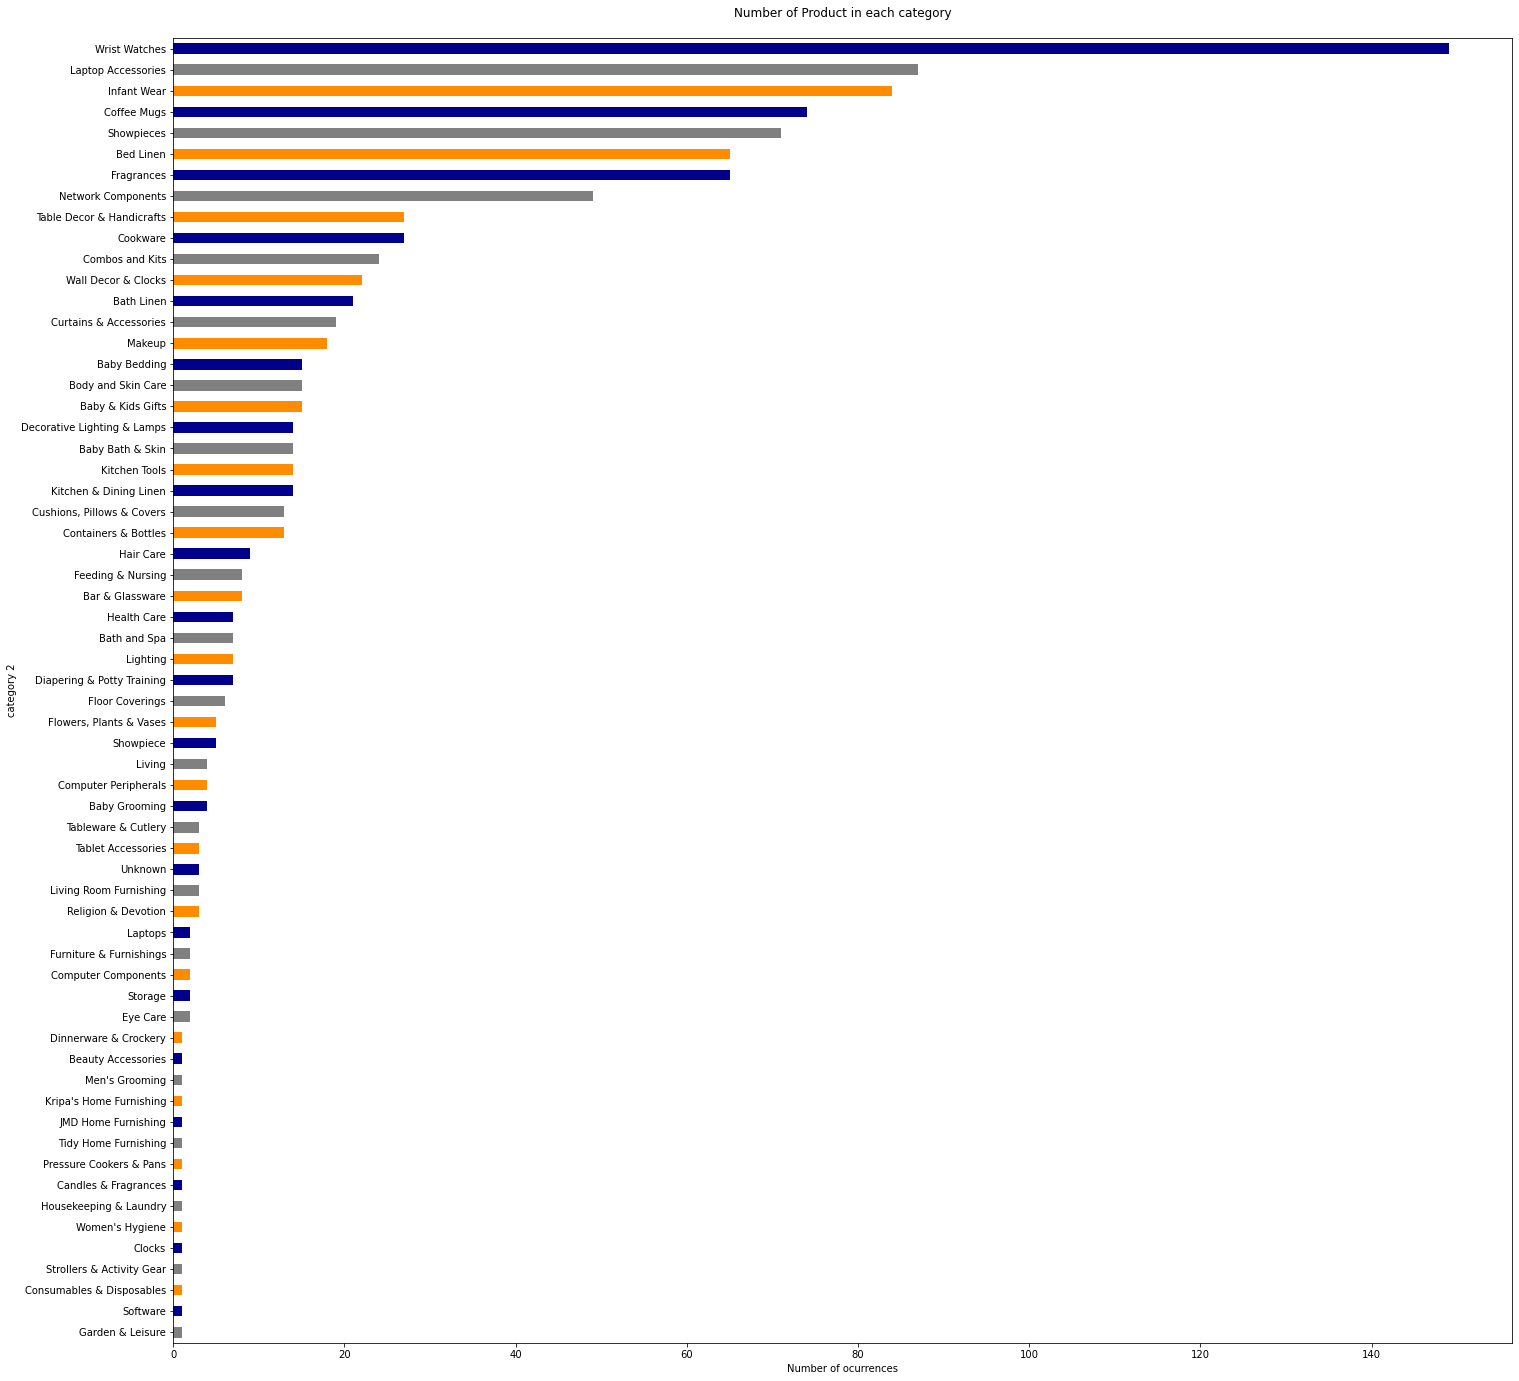

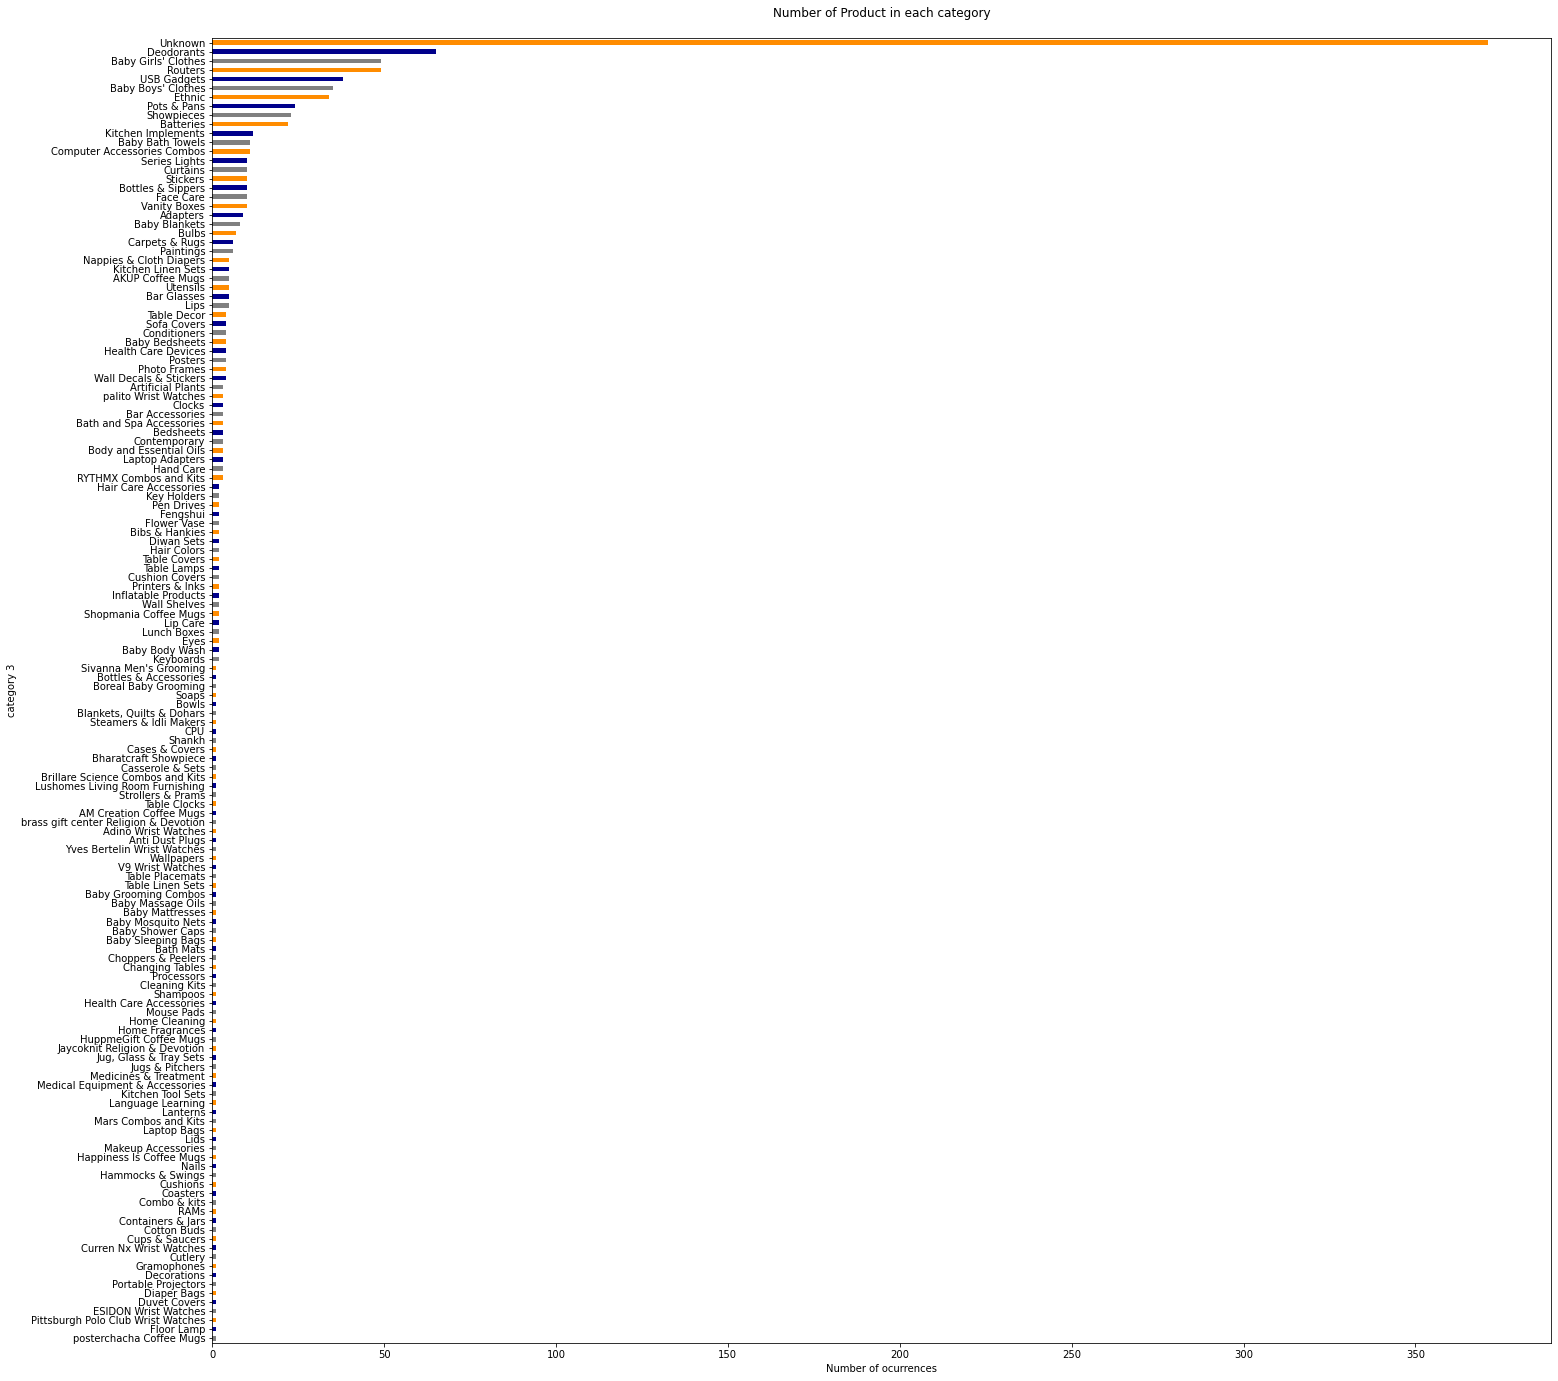

In [8]:
# Ploting the number of occurences for each level of category
for i in range(1,4):
    fig = plt.figure(figsize=(24,24))
    colors = ['grey','darkblue', 'darkorange']
    data_df.groupby('category {}'.format(i)).id.count().sort_values().plot.barh(
        ylim=0, color=colors, title= 'Number of Product in each category\n')
    plt.xlabel('Number of ocurrences', fontsize = 10)
    plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Products per Category Level {}.png'.format(i))

We will also take te least represented classes and gather them under a new class call 'Others' in the categeories of level 2 and we will apply the category of level 1 for the ones in the categories level 3.

In [9]:
# For the Categories level 2
for i, j in data_df['category 2'].value_counts().iteritems():
    if j < 10:
        data_df['category 2'].replace(to_replace=i, value='Others', inplace=True)

# For the Categories level 3
for i, j in data_df['category 3'].value_counts().iteritems():
    if j <10 :
        cat_index = data_df[data_df['category 3'] == i].index[0]
        cat_lvl_1 = data_df.loc[cat_index, 'category 1']
        data_df['category 3'].replace(to_replace=i, value=cat_lvl_1, inplace=True)

Unknown                        371
Deodorants                      65
Baby Girls' Clothes             49
Routers                         49
Home Decor & Festive Needs      47
Baby Care                       45
Beauty and Personal Care        44
Kitchen & Dining                40
USB Gadgets                     38
Baby Boys' Clothes              35
Ethnic                          34
Home Furnishing                 32
Computers                       28
Pots & Pans                     24
Showpieces                      23
Batteries                       22
Kitchen Implements              12
Baby Bath Towels                11
Computer Accessories Combos     11
Face Care                       10
Bottles & Sippers               10
Watches                         10
Stickers                        10
Vanity Boxes                    10
Curtains                        10
Series Lights                   10
Name: category 3, dtype: int64

# Text Data #

## Pre treatment ## 

To be able to use the text data, we will have to go through several transformations and cleaning. 

For each step, we will take a text example to best visualize the transformations.

Before, we will also make a copy of the dataframe.

In [10]:
# Copy of dataframe
data_df_copy = data_df.copy()

# Initializing the test text
test_text = "This is a text, made to illustrate the text's transformations \
processes that will and have occured."

### Tokenization ###

The first step is to separate the text data word by word and suppressing the ponctuation at the same time.

In [11]:
# Tokenizing the test text
tokenizer = nltk.RegexpTokenizer(r'\w+')
test_tokens = tokenizer.tokenize(test_text)
test_tokens

['This',
 'is',
 'a',
 'text',
 'made',
 'to',
 'illustrate',
 'the',
 'text',
 's',
 'transformations',
 'processes',
 'that',
 'will',
 'and',
 'have',
 'occured']

### Normalisation of the text ###

#### Lowercase #### 

We will put all the text in lowercase.

In [12]:
# Lowering the letters
test_tokens = tokenizer.tokenize(test_text.lower())
test_tokens

['this',
 'is',
 'a',
 'text',
 'made',
 'to',
 'illustrate',
 'the',
 'text',
 's',
 'transformations',
 'processes',
 'that',
 'will',
 'and',
 'have',
 'occured']

#### Stopwords suppression ####

Stopwords being quite light in information, we will get rid of them to ease the later processes.

In [13]:
stop_words = set(nltk.corpus.stopwords.words('english'))
clean_test_tokens = []
for word in test_tokens:
    if word not in stop_words:
        clean_test_tokens.append(word)

clean_test_tokens

['text',
 'made',
 'illustrate',
 'text',
 'transformations',
 'processes',
 'occured']

#### Lemmatisation and Stemming ####

Stemming consist of cutting words to get rid of prexifes, suffixes, etc.

Lemmatisation consist of reprensenting words by one word regardless of grammar and conjugation. For exemple, 'kings' and 'king' would be represented by 'king'. 'Were', 'was' and 'are' would be represented by 'be'.

We will use the lemmatisation process here as it will keep more context and thus information.

In [14]:
# Function to go from the Part of Speech tags to the lemmatitizer attribute
def get_wordnet_pos(treebank_tag):

    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return nltk.corpus.wordnet.NOUN

In [15]:
# Tagging the tokens
pos_tagger = nltk.pos_tag(clean_test_tokens)
tagged_tokens = list(map(lambda x: (x[0], get_wordnet_pos(x[1])), pos_tagger))

tagged_tokens

[('text', 'n'),
 ('made', 'v'),
 ('illustrate', 'a'),
 ('text', 'a'),
 ('transformations', 'n'),
 ('processes', 'n'),
 ('occured', 'v')]

In [16]:
# Lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmated_test_tokens = []

for word, tag in tagged_tokens:
    if tag is None:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmated_test_tokens.append(lemmatized_word)
    else:
        lemmatized_word = lemmatizer.lemmatize(word, pos=tag)
        lemmated_test_tokens.append(lemmatized_word)

lemmated_test_tokens

['text', 'make', 'illustrate', 'text', 'transformation', 'process', 'occur']

We will now apply all these pre treatments to our descriptions.

In [17]:
# Making a function for pretreatments
def text_pretreatments(text):
    # Tokenizing and lowering cases
    tokens = tokenizer.tokenize(text.lower())
    
    # Suppressing Stop Words
    clean_tokens = []
    for word in tokens:
        if word not in stop_words:
            clean_tokens.append(word)
            
    # Tagging the tokens
    pos_tagger = nltk.pos_tag(clean_tokens)
    tagged_tokens = list(map(lambda x: (x[0], get_wordnet_pos(x[1])), pos_tagger))
    
    # Lemmatization
    lemmated_tokens = []
    for word, tag in tagged_tokens:
        if tag is None:
            lemmatized_word = lemmatizer.lemmatize(word)
            lemmated_tokens.append(lemmatized_word)
        else:
            lemmatized_word = lemmatizer.lemmatize(word, pos=tag)
            lemmated_tokens.append(lemmatized_word)
            
    return lemmated_tokens

In [18]:
# Transforming the description into the the associated tokens
for i in range(len(data_df)):
    data_df.loc[i, 'description'] = text_pretreatments(data_df.loc[i, 'description'])

### Bag of words ###

We will assemble all the words in different bags of words conveying a same idea. (here our products categories)

In [21]:
# Finding all the words in the database
all_words = find_all_words(data_df, 'description')

# Creating bags of words for each category level
category_1_df = create_BoW_dataframe('category 1')
category_2_df = create_BoW_dataframe('category 2')
category_3_df = create_BoW_dataframe('category 3')

Time needed for category 1 is 8.865172624588013 seconds.
Time needed for category 2 is 10.780231714248657 seconds.
Time needed for category 3 is 11.151150226593018 seconds.


Time elapsed : 1.480342149734497 s.


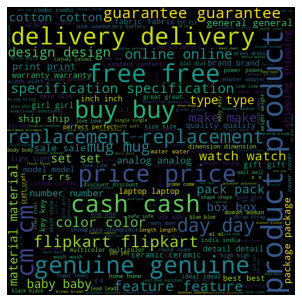

In [23]:
t0 = time()
all_text = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=800).generate(all_text)
plt.figure(figsize=(4,4), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
t1 = time()
print('Time elapsed : {} s.'.format(t1-t0))
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'WordCloud_All.png')
plt.show()

Time elapsed : 9.38004446029663 s.



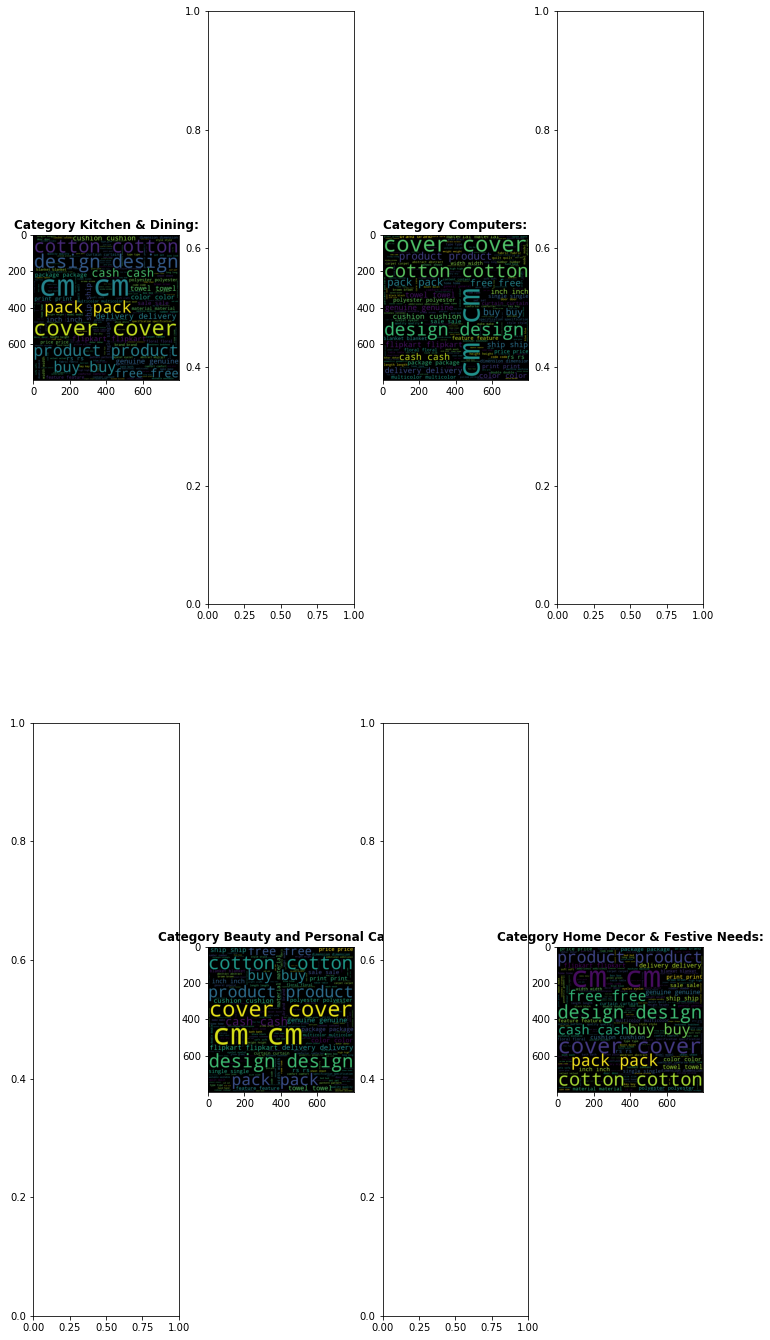

In [24]:
create_WC_from_DF(category_1_df)

Time elapsed : 32.5178439617157 s.



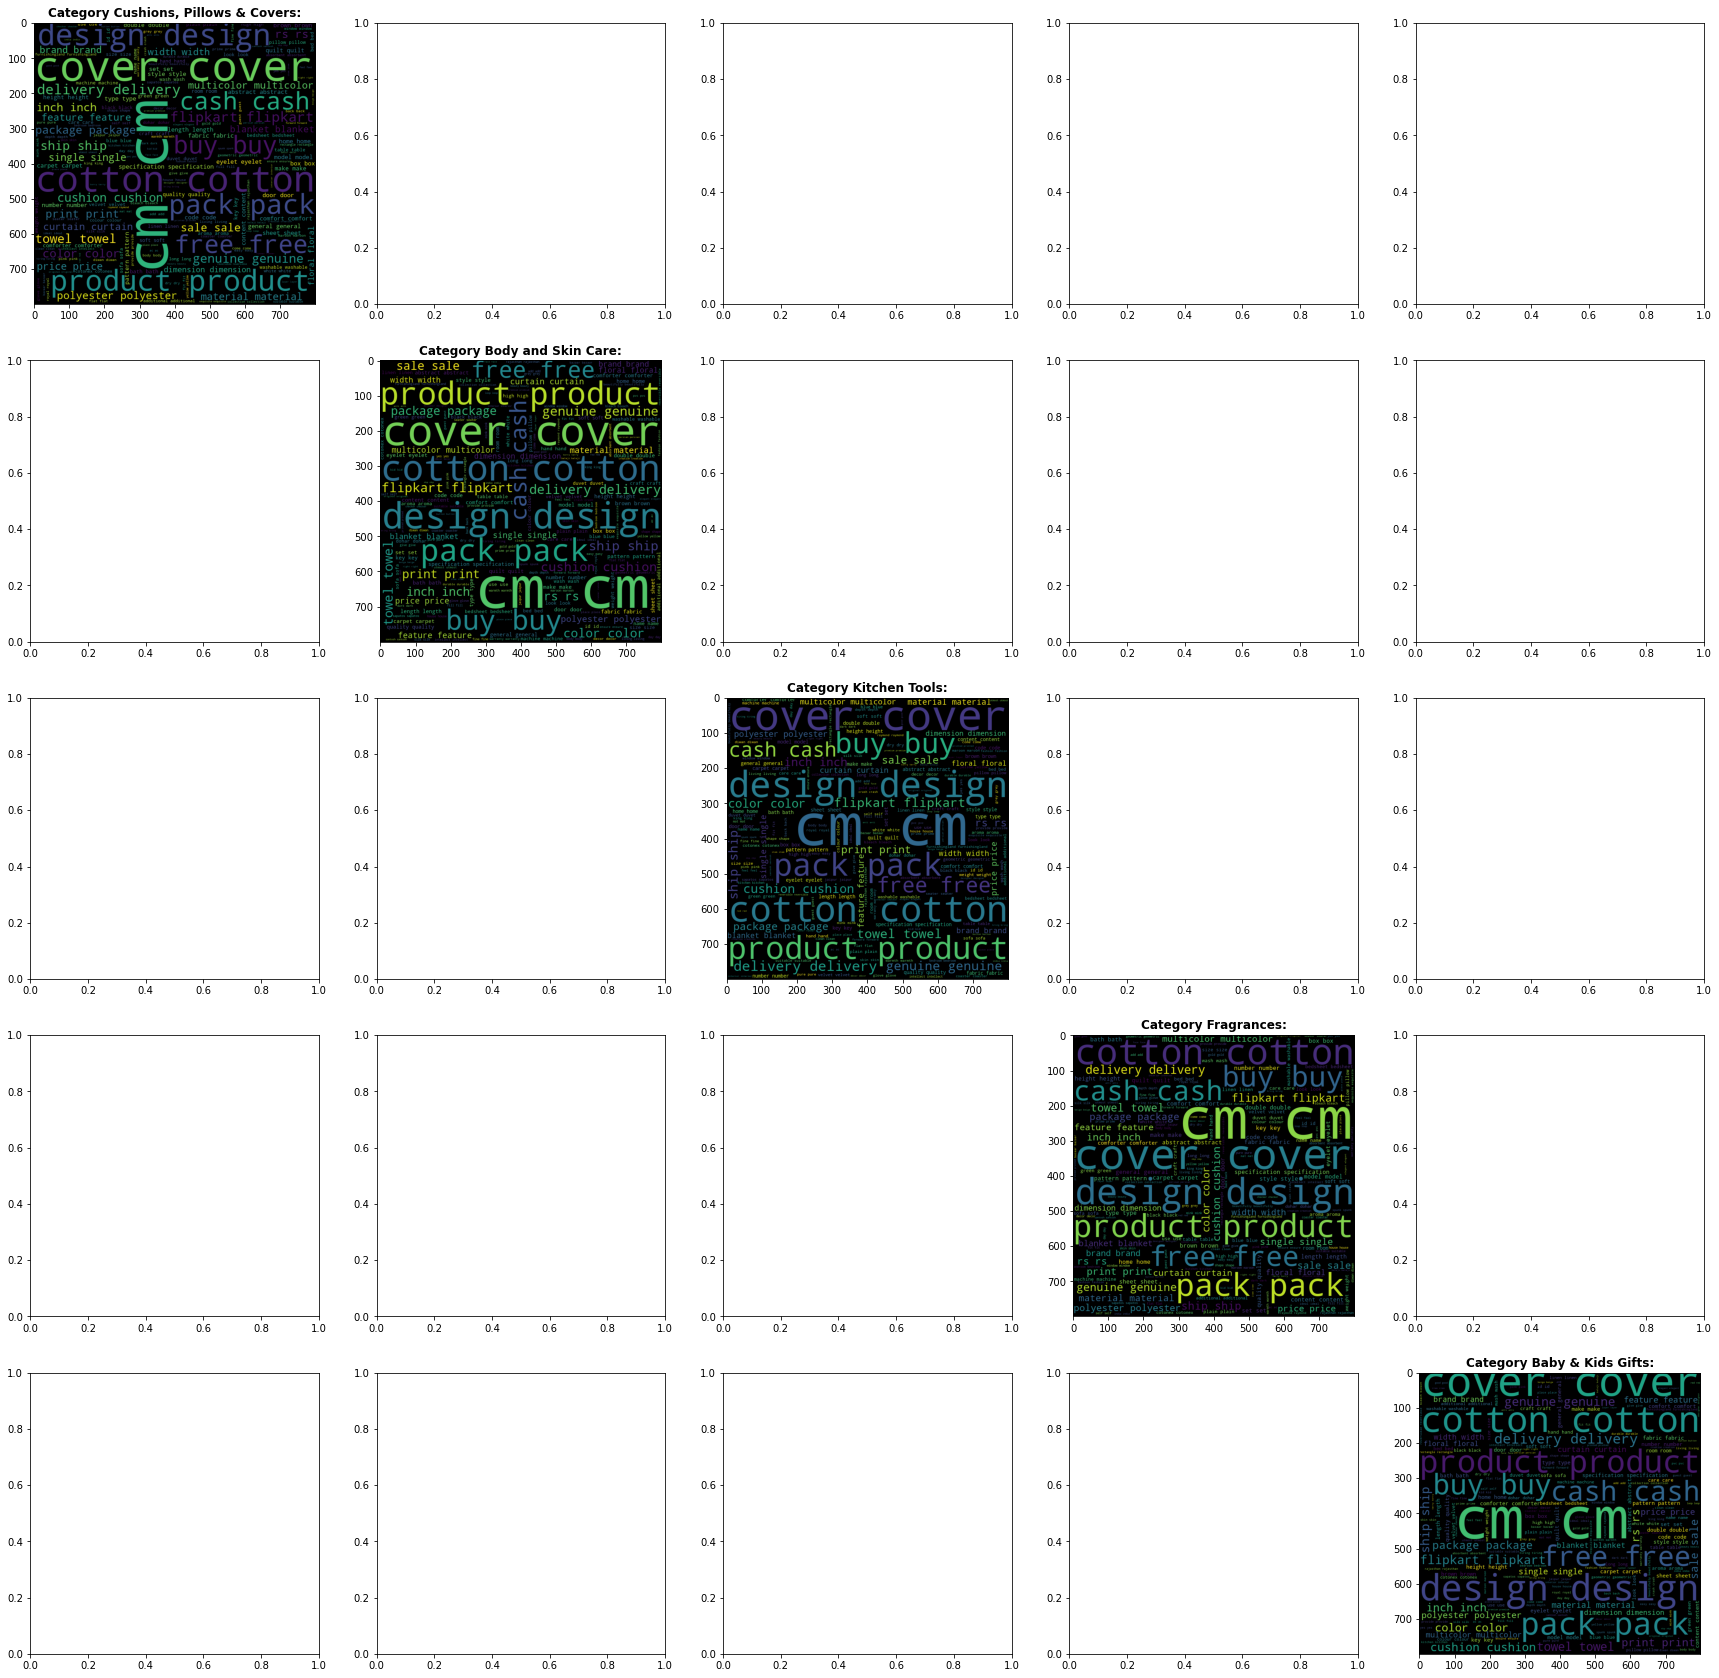

In [25]:
create_WC_from_DF(category_2_df)

Time elapsed : 33.2825984954834 s.



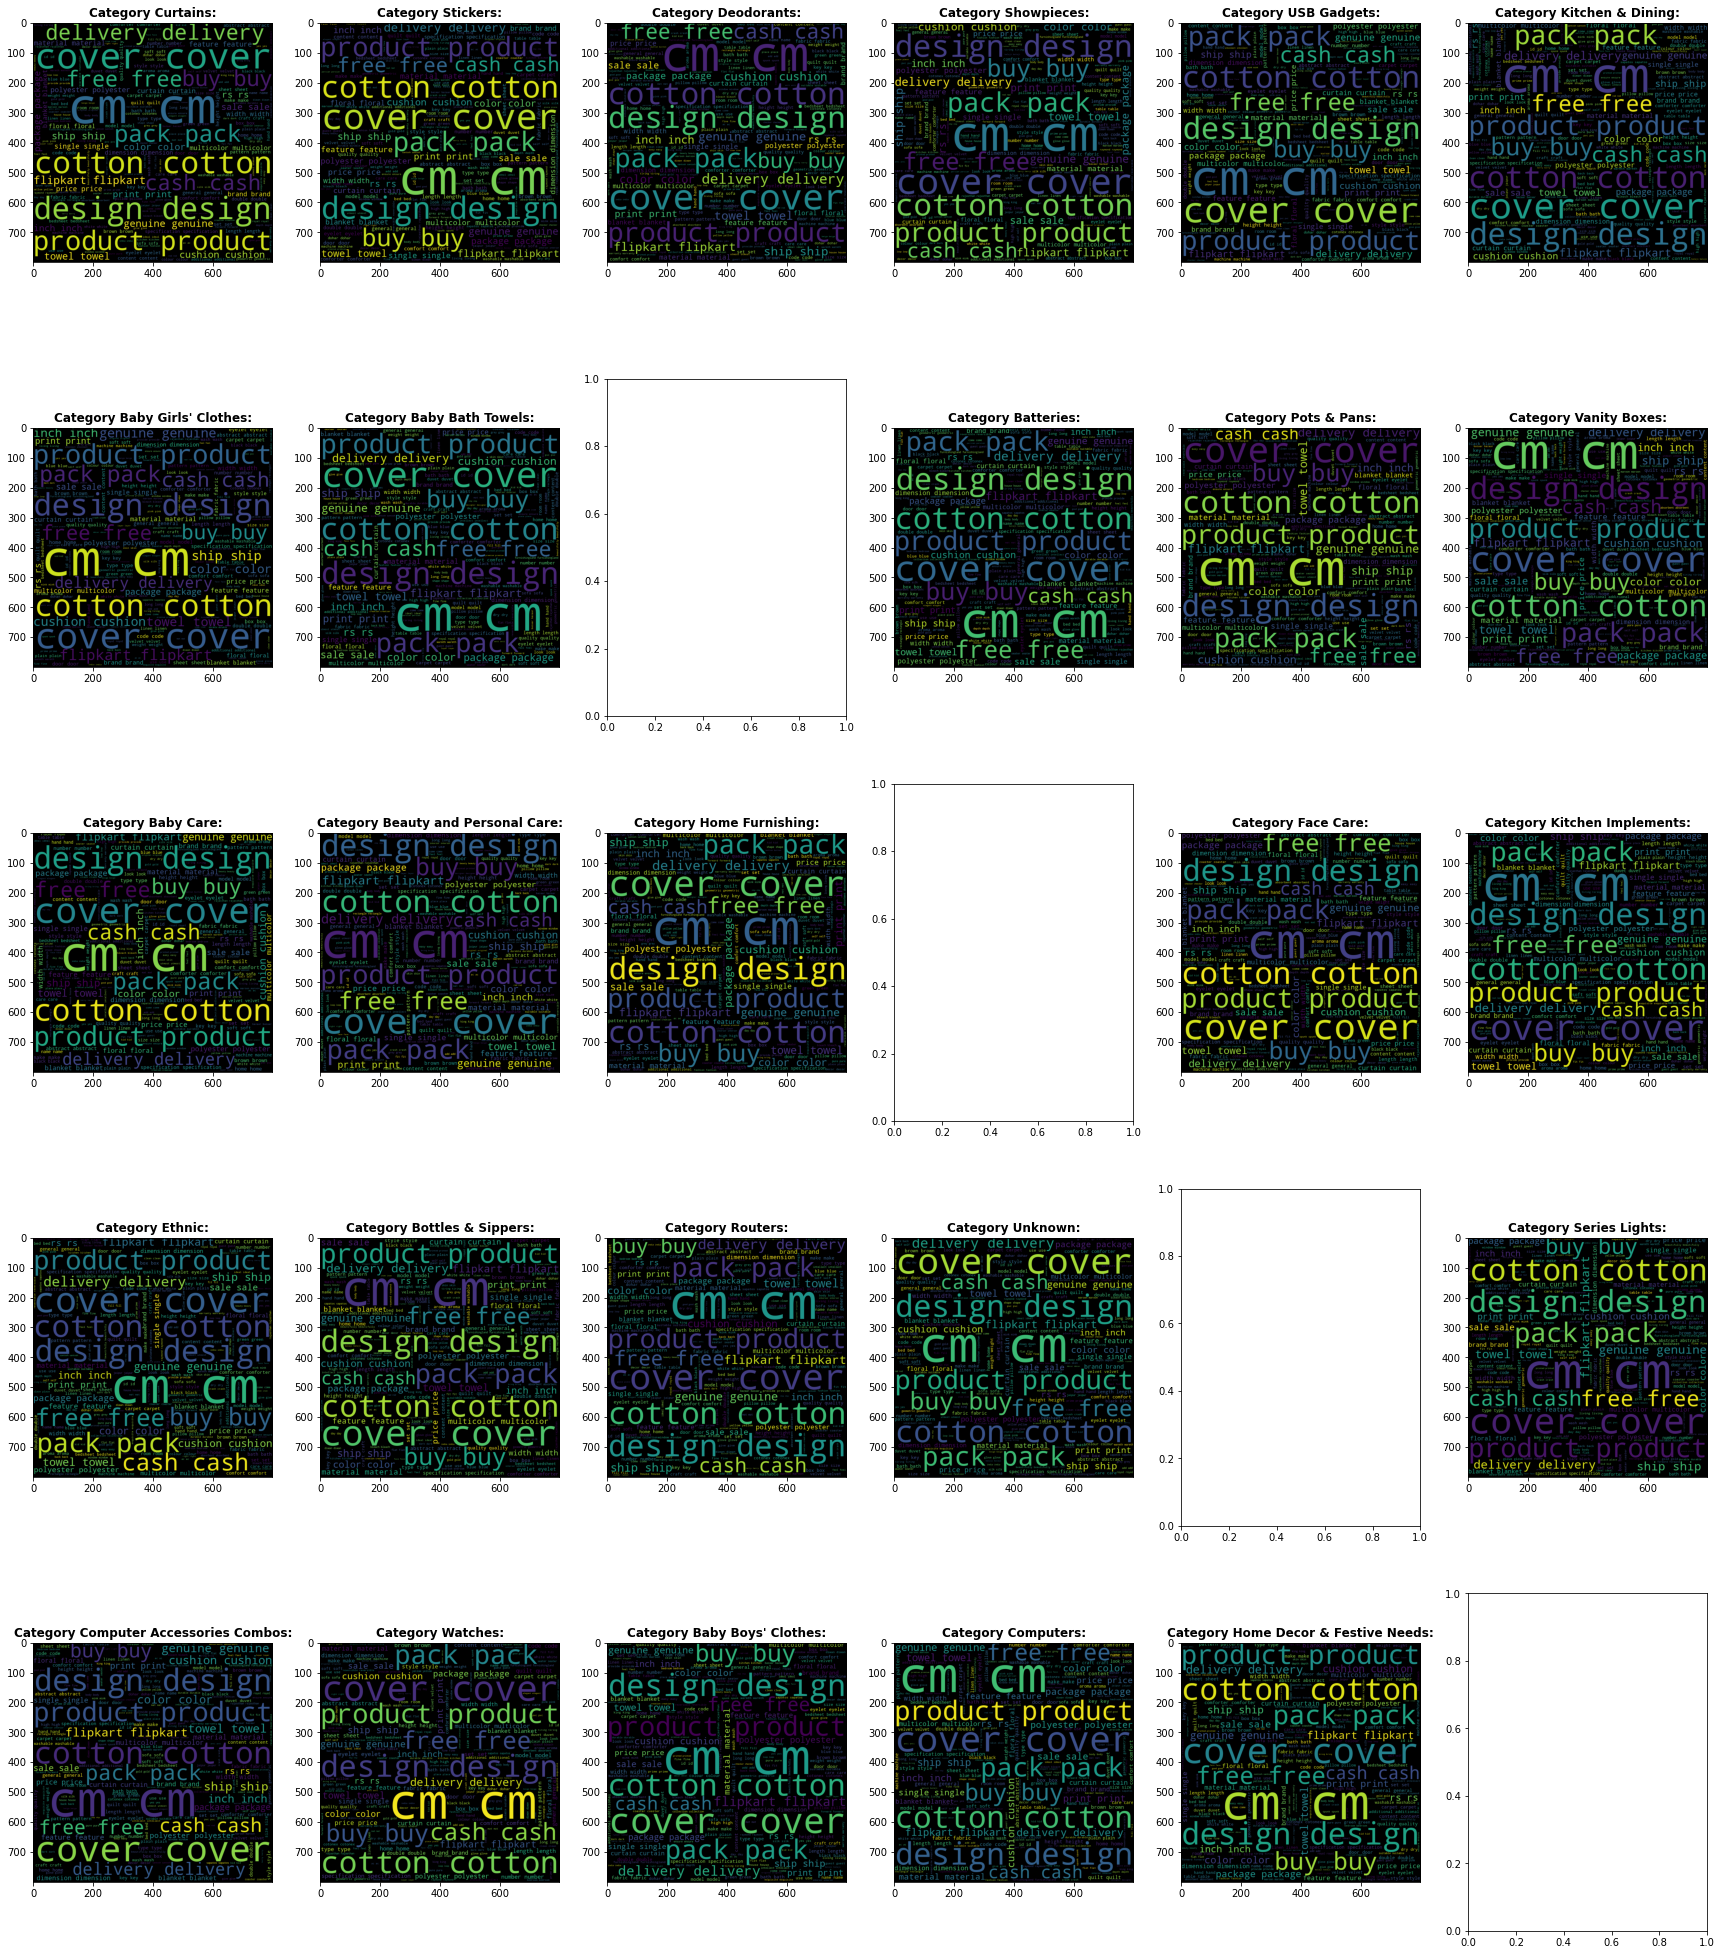

In [26]:
create_WC_from_DF(category_3_df)

### Term Frequency - Inverse Document Frequency (tf-idf) ###

In a same goal but with different means, we will link the words between them. 

In [27]:
# Initializaing the tf-idf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words='english')

# Transforming the descriptions into vectors
features = tfidf.fit_transform(data_df_copy['description']).toarray()
labels_1 = data_df_copy['category 1']
labels_2 = data_df_copy['category 2']
labels_3 = data_df_copy['category 3']

print("Each of the {} description is represented by {} features (TF-IDF score of \
unigrams and bigrams)".format(features.shape[0], features.shape[1]))

Each of the 1050 description is represented by 2227 features (TF-IDF score of unigrams and bigrams)


We can now visualize it with t-SNE.

In [28]:
# Computing t-SNE
tsne = TSNE(n_components=2, perplexity=600, n_iter=600, init='pca')
t0 = time()
X_tsne = tsne.fit_transform(features)
t1 = time()
tsne_time = t1-t0
print('Time elapsed : {} s.'.format(tsne_time))

Time elapsed : 5.859964609146118 s.


Then, we can look at the data distribution to see if we see any pattern.

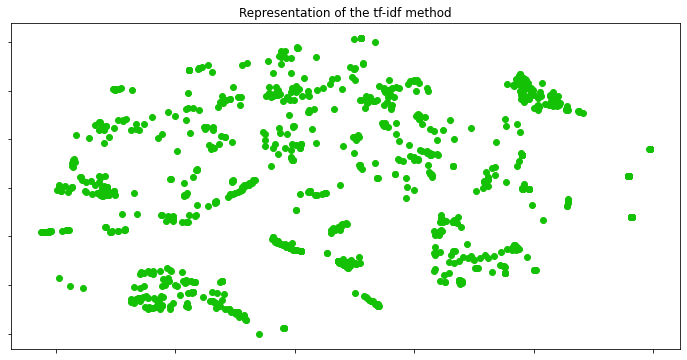

In [204]:
# Representation of tf-idf method
x_vals = X_tsne[:,0]
y_vals = X_tsne[:,1]

fig, ax = plt.subplots(figsize = (12,6))
color_palette = ['#15c105']
ax.set_prop_cycle(color=color_palette)
ax.scatter(x_vals, y_vals)
    
ax.set_title('Representation of the tf-idf method')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Text tf-idf.png')
plt.show()

## Word Embedding ##

Using word2vect, we will embedd our text data, the last step before actualy doing the classifier. 

In [33]:
# Continuous Bag Of Words Model predicts the current word given the context words.
CBOW_model = Word2Vec(data_df['description'], min_count=5)
CBOW_vectors = np.asarray(CBOW_model.wv.vectors)
CBOW_labels = np.asarray(CBOW_model.wv.index_to_key)

# Skip Gram model predicts the surrouding context words given the current word.
SkipGram_model = Word2Vec(data_df['description'], min_count=5, sg=1)
SkipGram_vectors = np.asarray(SkipGram_model.wv.vectors)
SkipGram_labels = np.asarray(SkipGram_model.wv.index_to_key)

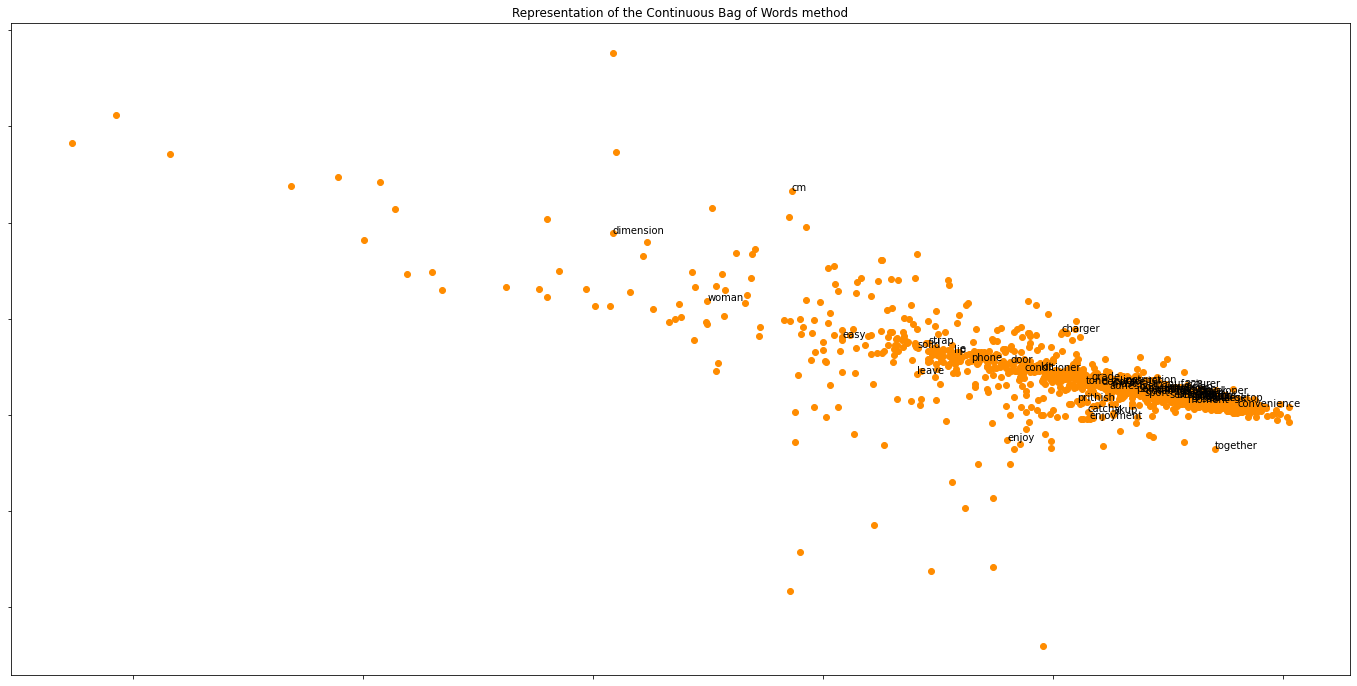

In [48]:
# Representation of Continuous Bag of Words Model
x_vals = [v[0] for v in CBOW_vectors]
y_vals = [v[1] for v in CBOW_vectors]

fig, ax = plt.subplots(figsize = (12,6))
color_palette = ['darkorange']
ax.set_prop_cycle(color=color_palette)
ax.scatter(x_vals, y_vals)

indices = list(range(len(CBOW_labels)))
selected_indices = random.sample(indices, 60)
for i in selected_indices:
    plt.annotate(CBOW_labels[i], (x_vals[i], y_vals[i]))
    
ax.set_title('Representation of the Continuous Bag of Words method')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Text CBOW.png')
plt.show()

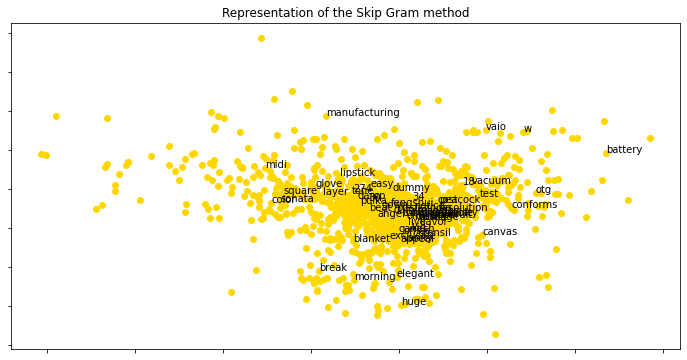

In [179]:
# Representation of Skip Gram Model
x_vals = [v[0] for v in SkipGram_vectors]
y_vals = [v[1] for v in SkipGram_vectors]
fig, ax = plt.subplots(figsize = (12,6))
color_palette = ['gold']
ax.set_prop_cycle(color=color_palette)
ax.scatter(x_vals, y_vals)

indices = list(range(len(SkipGram_labels)))
selected_indices = random.sample(indices, 60)
for i in selected_indices:
    plt.annotate(SkipGram_labels[i], (x_vals[i], y_vals[i]))
    
ax.set_title('Representation of the Skip Gram method')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Text SkipGram.png')
plt.show()

### t-SNE ### 

We will visualize the different method with t-SNE and how the categories are distributed.

Firstly, we initialize the t-SNE.

In [209]:
# Creating vectorization of description from Word2Vec methods
X_CBOW = create_W2V_X(CBOW_model)
X_SkipGram = create_W2V_X(SkipGram_model)

# Computing t-SNE
tsne = TSNE(n_components=2, perplexity=600, n_iter=600, init='pca')

X_tsne_tfidf = tsne_transformation(features, 'tf-idf')
X_tsne_CBOW = tsne_transformation(X_CBOW, 'Continuous Bag Of Words')
X_tsne_SkipGram = tsne_transformation(X_SkipGram, 'Skip Gram')

Time elapsed for the tf-idf method: 5.898293495178223 s.
Time elapsed for the Continuous Bag Of Words method: 5.8336663246154785 s.
Time elapsed for the Skip Gram method: 6.872591495513916 s.


Finaly, we can look at it depending on the different level of categories to see if there is one correponding more closely to the clusters.

#### Categories of level 1 ####

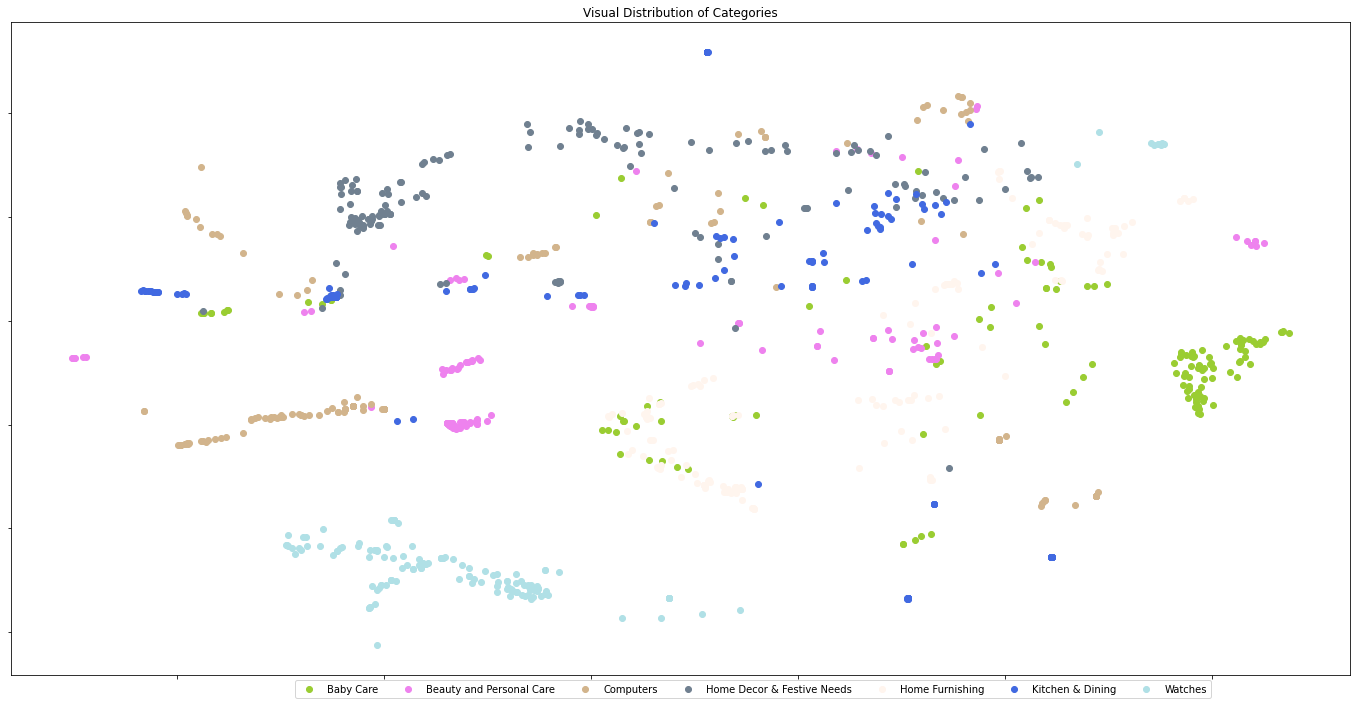

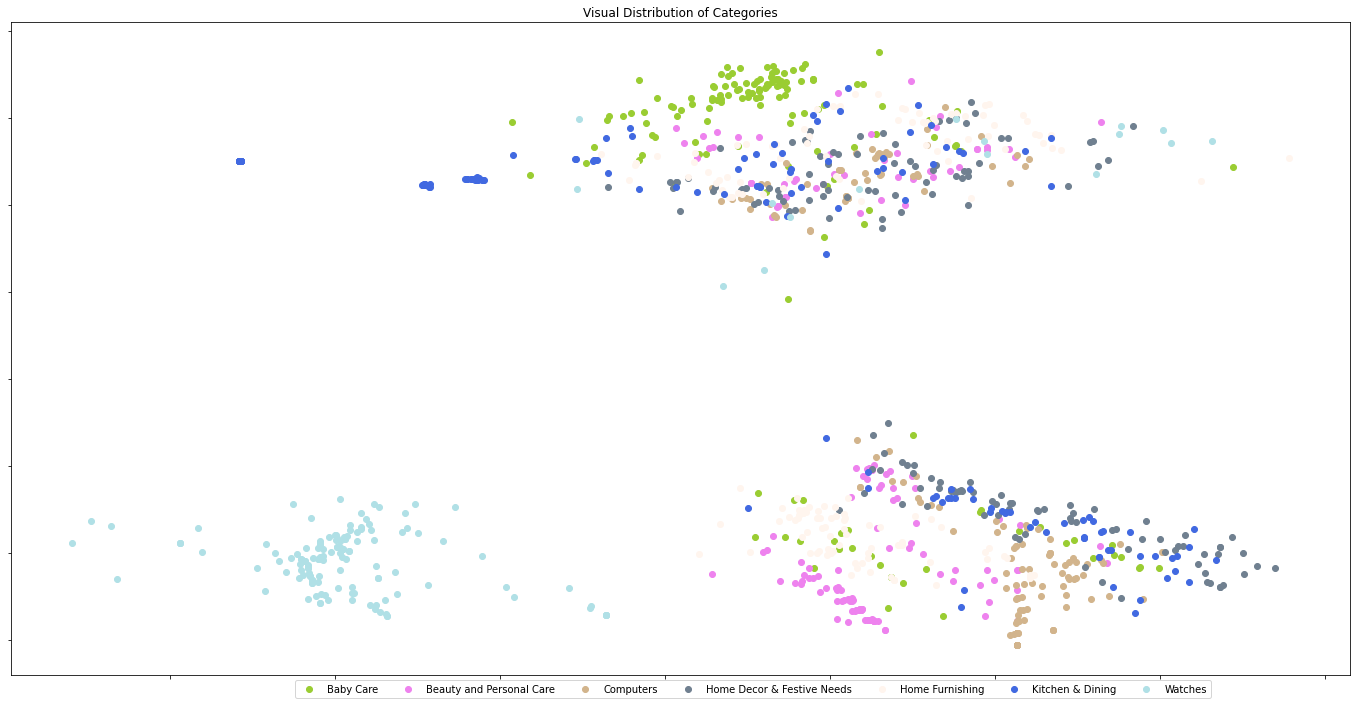

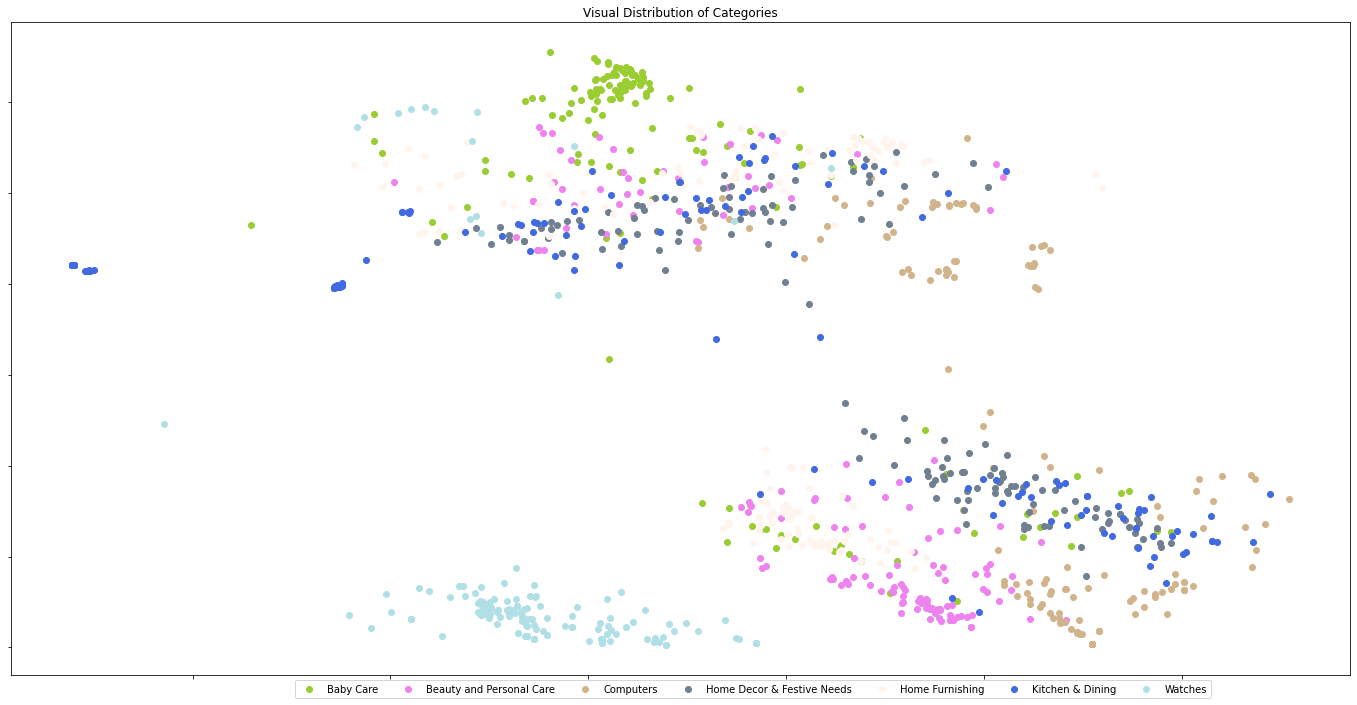

In [243]:
visualize_tsne(X_tsne_tfidf, labels_1, 'tfidf', '1')
visualize_tsne(X_tsne_CBOW, labels_1, 'CBOW', '1')
visualize_tsne(X_tsne_SkipGram, labels_1, 'SkipGram', '1')

#### Categories of level 2 ####

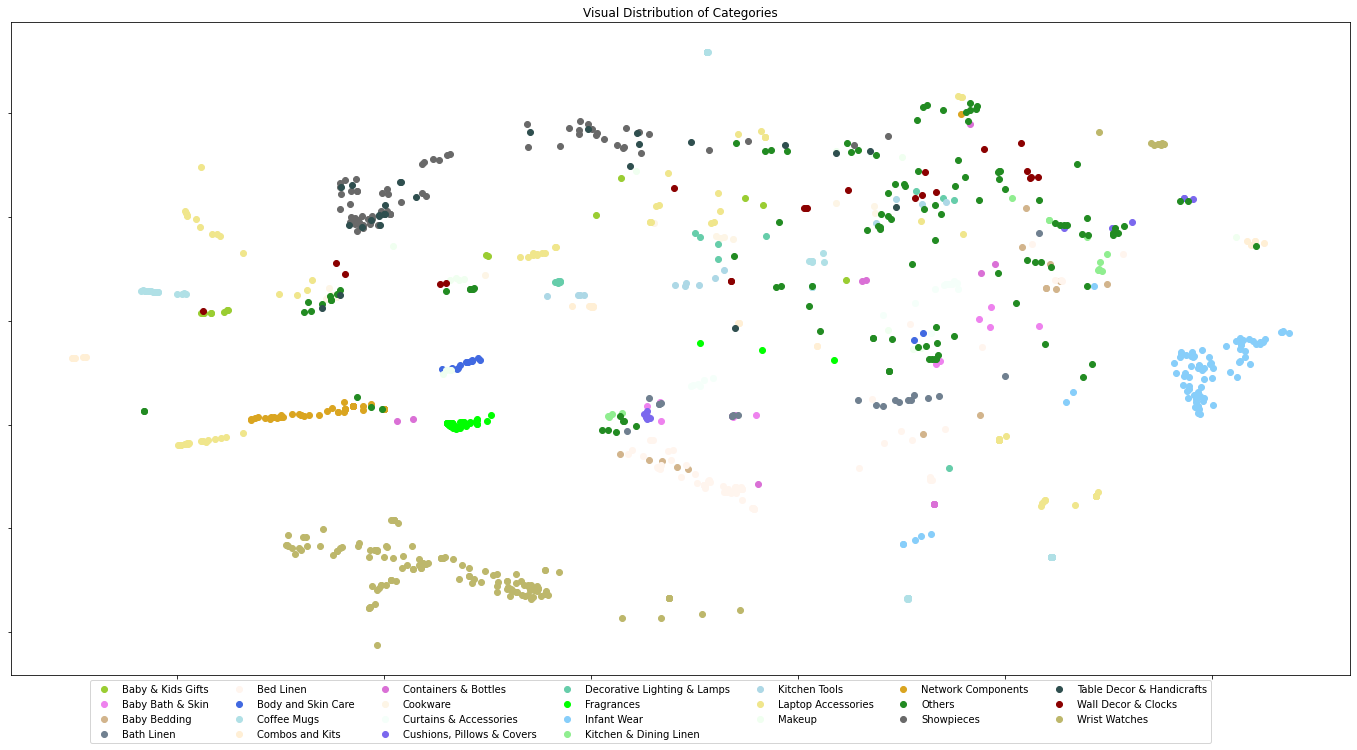

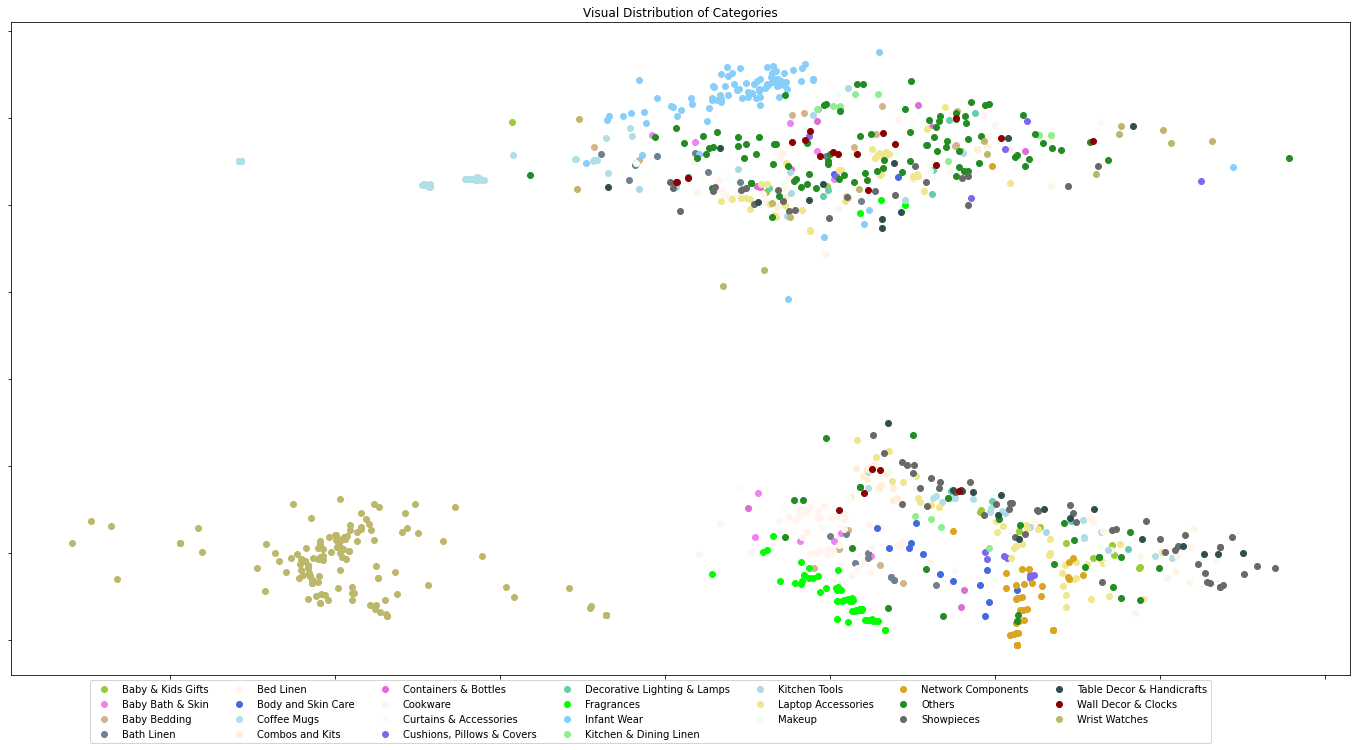

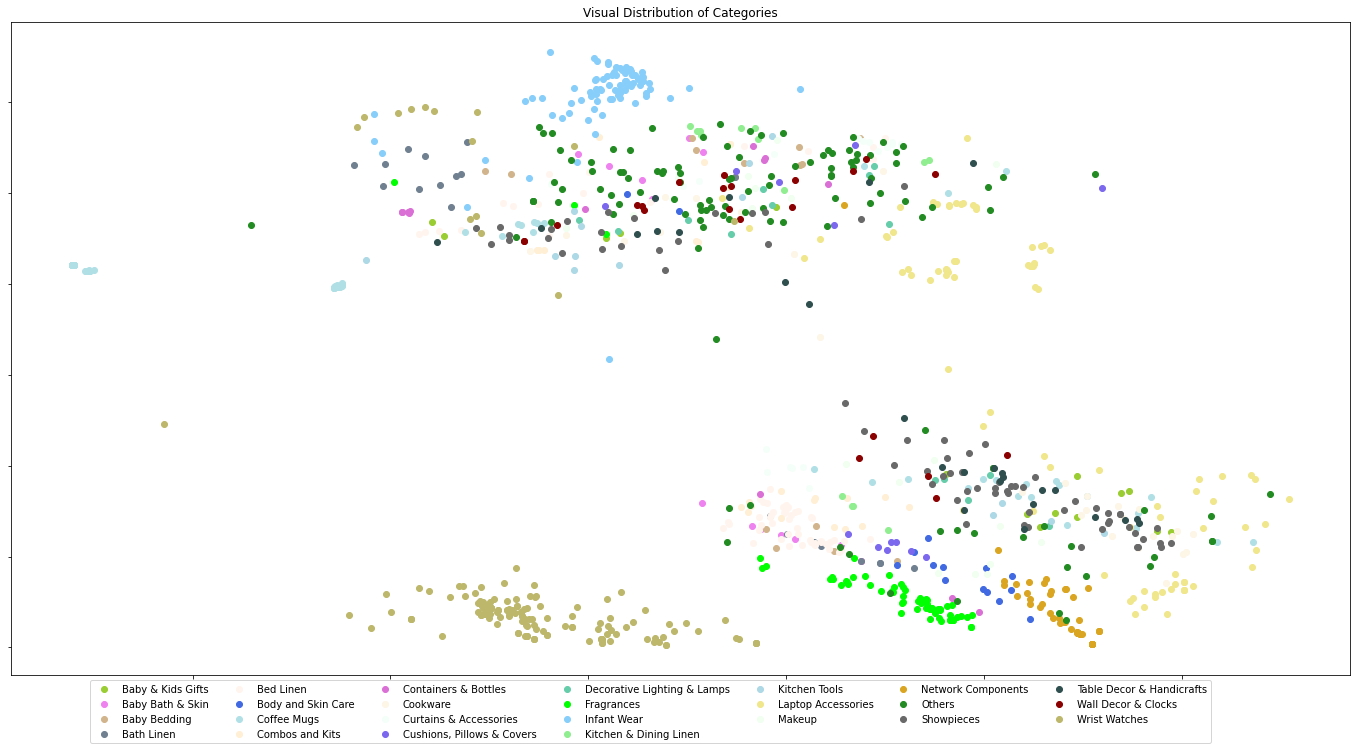

In [244]:
visualize_tsne(X_tsne_tfidf, labels_2, 'tfidf', '2')
visualize_tsne(X_tsne_CBOW, labels_2, 'CBOW', '2')
visualize_tsne(X_tsne_SkipGram, labels_2, 'SkipGram', '2')

#### Categories of level 3 ####

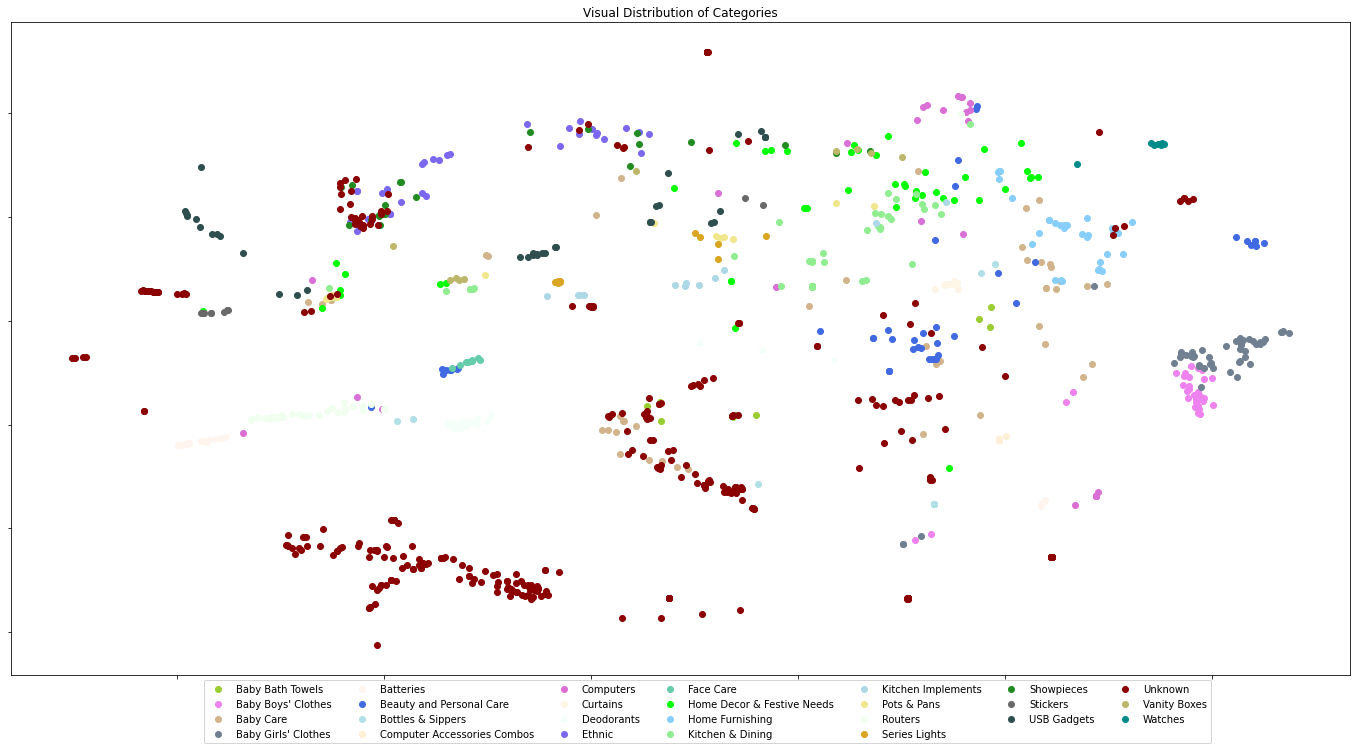

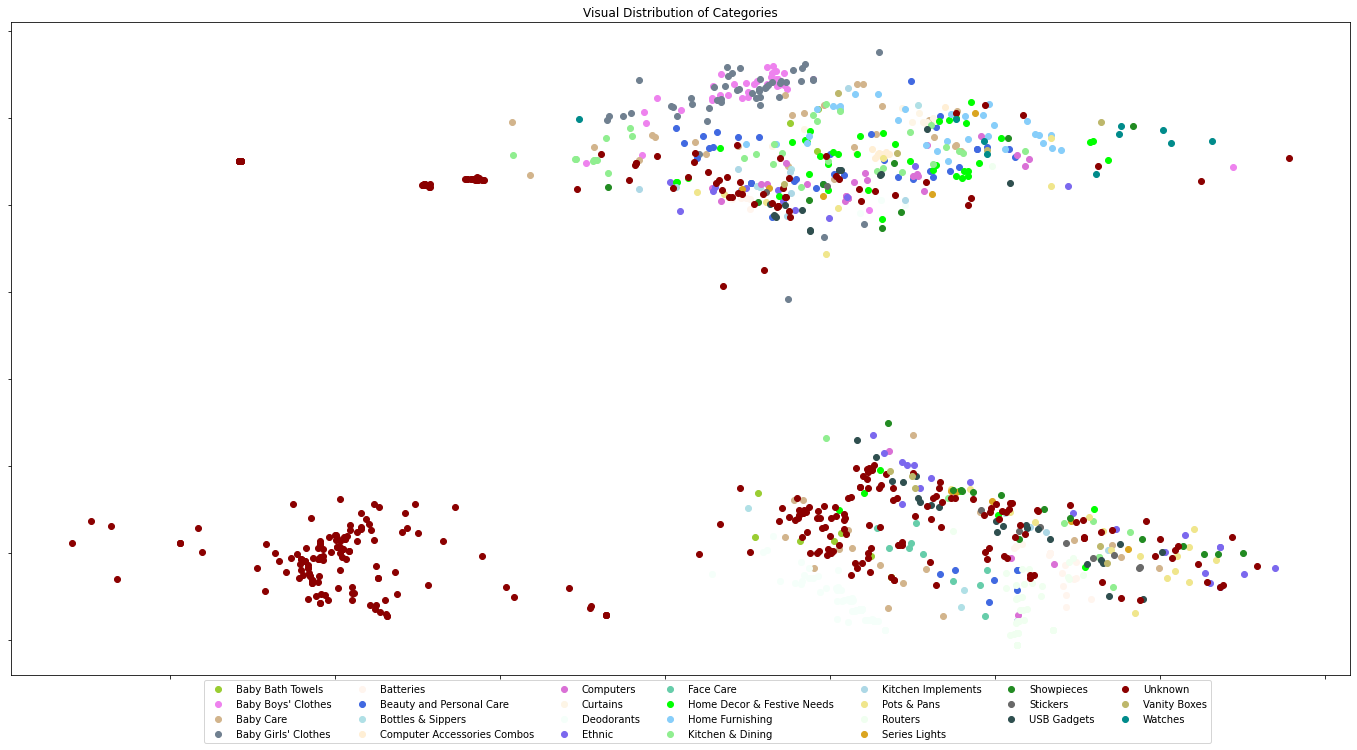

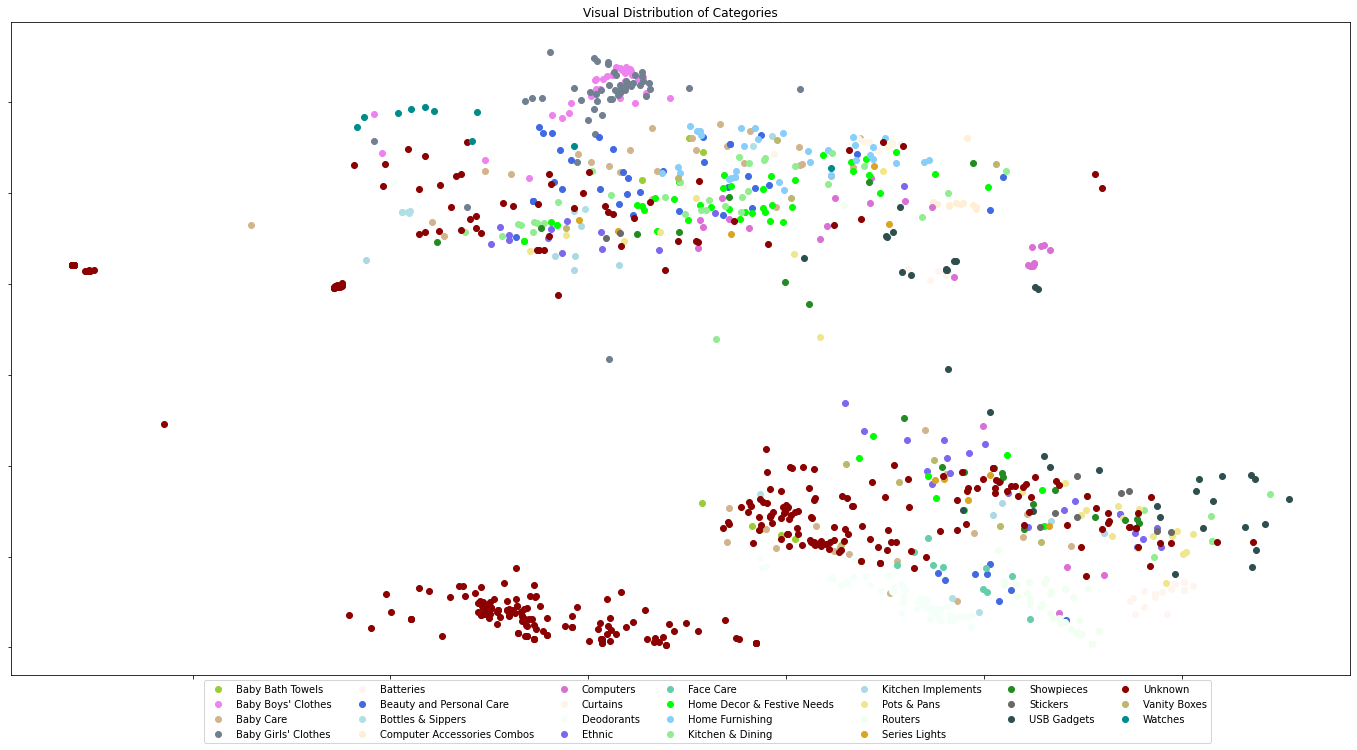

In [245]:
visualize_tsne(X_tsne_tfidf, labels_3, 'tfidf', '3')
visualize_tsne(X_tsne_CBOW, labels_3, 'CBOW', '3')
visualize_tsne(X_tsne_SkipGram, labels_3, 'SkipGram', '3')

## Classifying ##

### NaiveBayesClassifier ###

We will first use a Multinomial Naive Bayes classifier on our data and see the results. 

The first step will be to separate our data into train and test sets depending on the level of category wanted and method.

In [267]:
# We separate our data into test and train sets for all labels and all methods
label_list = [labels_1, labels_2, labels_3]
for i in range(len(label_list)):
    globals()['tfidf_set_{}'.format(i+1)] = train_test_separation(features, label_list[i])
    globals()['CBOW_set_{}'.format(i+1)] = train_test_separation(X_CBOW, label_list[i])
    globals()['SkipGram_set_{}'.format(i+1)] = train_test_separation(X_SkipGram, label_list[i])

#### Categories of Level 1 ####

Our Naive Bayes Classifier has an accuracy of : 92.38% in 0.01s.


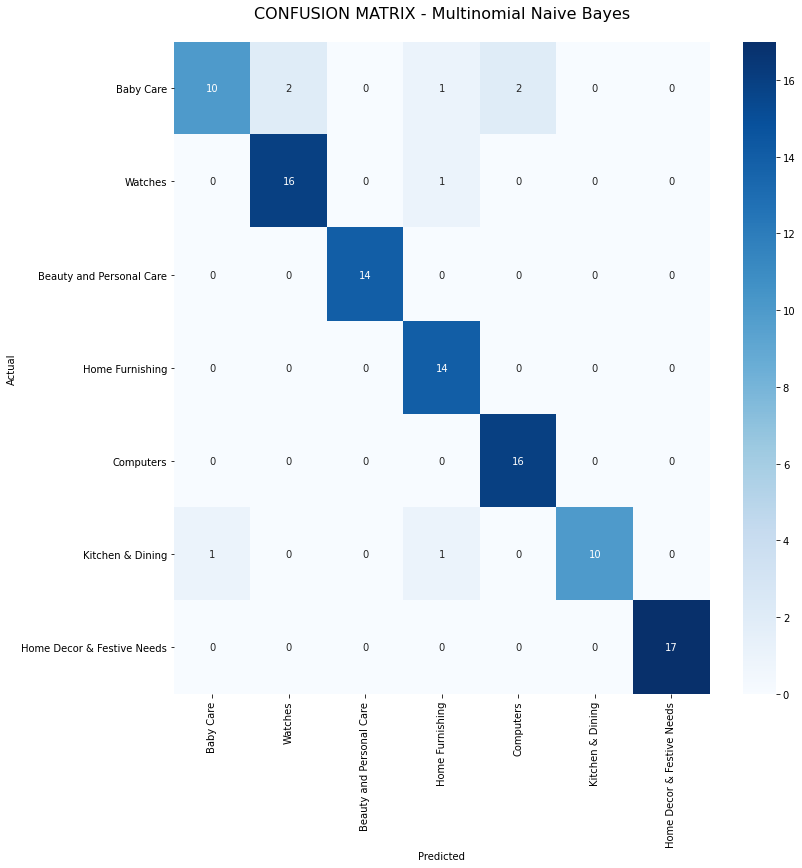

In [287]:
MNB_model = MultinomialNB()
classic_classifier(MNB_model, tfidf_set_1, 'Multinomial Naive Bayes', labels_1)

#### Categories of Level 2 ####

Our Naive Bayes Classifier has an accuracy of : 74.29% in 0.01s.


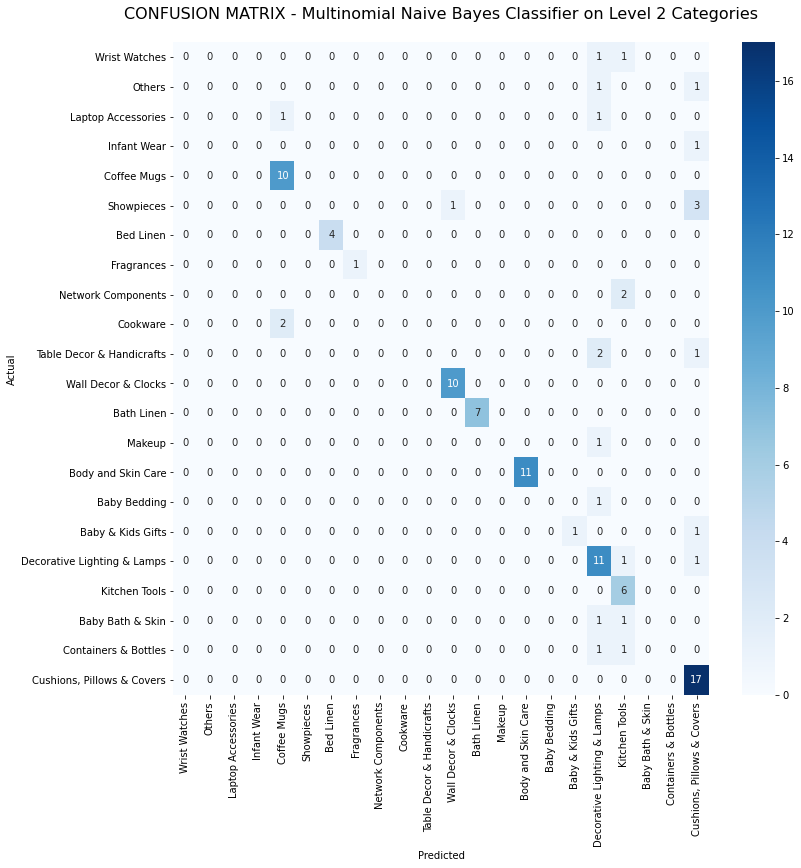

In [38]:
# We train the classifier
t0 = time()
MNB_model_2 = MultinomialNB()
MNB_model_2.fit(X_train_2, y_train_2)

# We try to predict the test set
MNB_y_pred_2 = MNB_model_2.predict(X_test_2)
t1 = time()
MNB_model_2_time = t1-t0

# We evaluate the accuracy of the model
MNB_accuracy_2 = metrics.accuracy_score(y_test_2, MNB_y_pred_2)*100
print('Our Naive Bayes Classifier has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(MNB_accuracy_2, MNB_model_2_time))

# We create a confusion matrix to see where are the most problematic categories
category_label = list(dict(data_df['category 2'].value_counts()).keys())
test_list = []
test_list.extend(list(y_test_2))
test_list.extend(list(MNB_y_pred_2))
for lbl in category_label:
    if lbl not in test_list:
        category_label.remove(lbl)

conf_mat = confusion_matrix(y_test_2, MNB_y_pred_2)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_label, 
            yticklabels=category_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Naive Bayes Classifier on Level 2 Categories\n", size=16)
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix MNB Level 2.png')

#### Categories of Level 3 ####

Our Naive Bayes Classifier has an accuracy of : 66.67% in 0.01s.


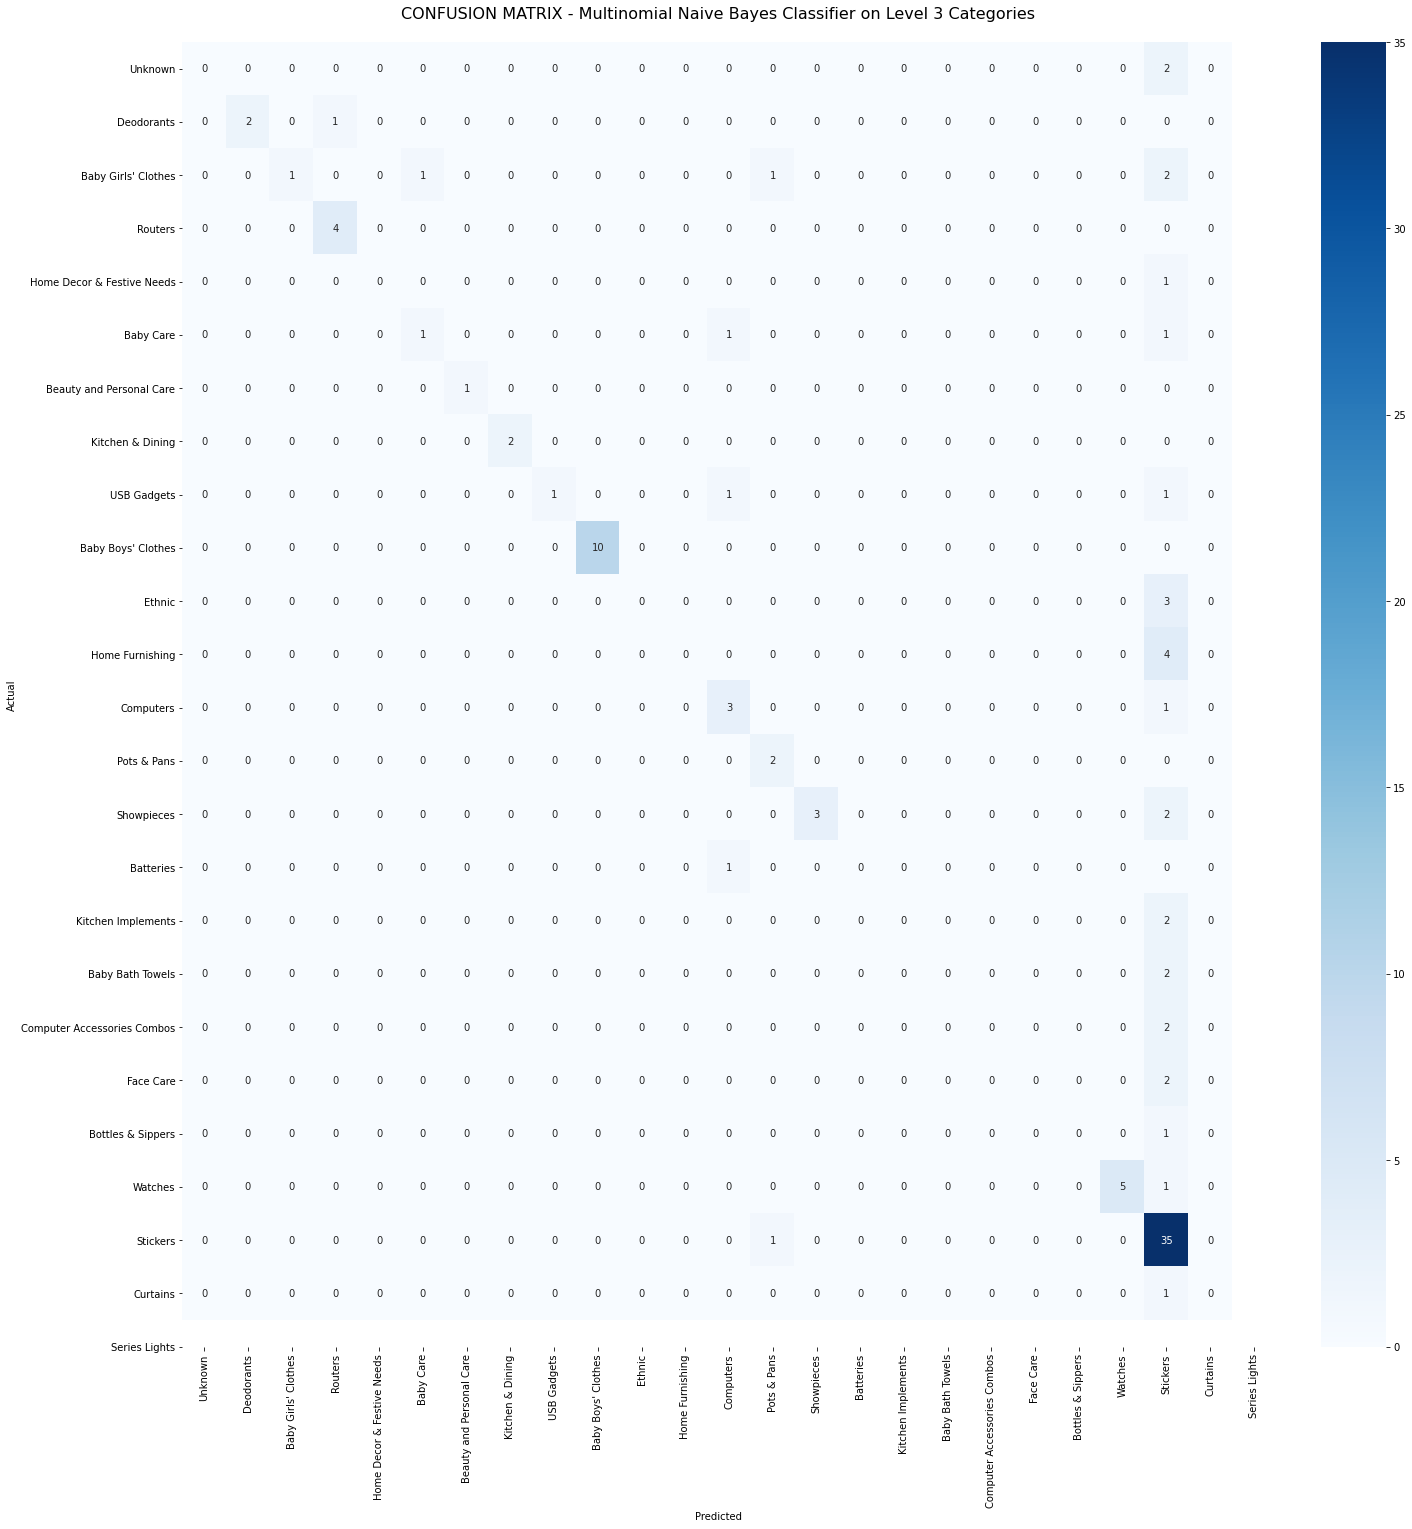

In [39]:
# We train the classifier
t0 = time()
MNB_model_3 = MultinomialNB()
MNB_model_3.fit(X_train_3, y_train_3)

# We try to predict the test set
MNB_y_pred_3 = MNB_model_3.predict(X_test_3)
t1 = time()
MNB_model_3_time = t1-t0

# We evaluate the accuracy of the model
MNB_accuracy_3 = metrics.accuracy_score(y_test_3, MNB_y_pred_3)*100
print('Our Naive Bayes Classifier has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(MNB_accuracy_3, MNB_model_3_time))

# We create a confusion matrix to see where are the most problematic categories
category_label = list(dict(data_df['category 3'].value_counts()).keys())
test_list = []
test_list.extend(list(y_test_3))
test_list.extend(list(MNB_y_pred_3))
for lbl in category_label:
    if lbl not in test_list:
        category_label.remove(lbl)
        
conf_mat = confusion_matrix(y_test_3, MNB_y_pred_3)
fig, ax = plt.subplots(figsize=(24,24))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_label, 
            yticklabels=category_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Multinomial Naive Bayes Classifier on Level 3 Categories\n", size=16)
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix MNB Level 3.png')

The results are already quite satisfying, especialy for the level 1 categories and could be further enhanced by crossvalidation.

### Random Forest ###

We will test a Random Forest to see if we obtain better results. 

#### Categories of Level 1 ####

Our Random Forest has an accuracy of : 91.43% in 0.52s.


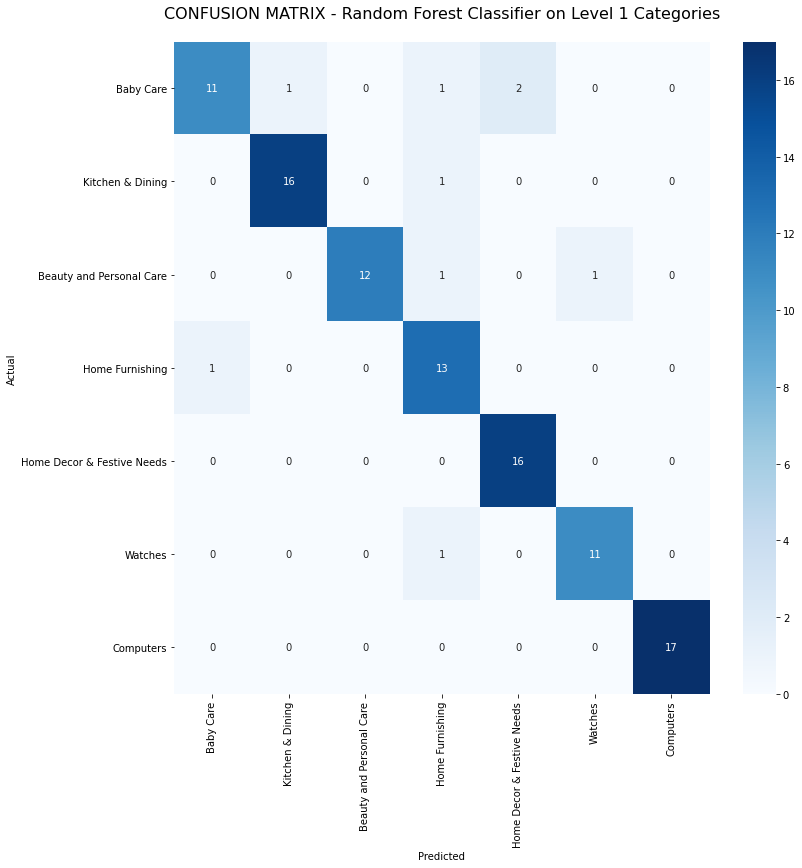

In [40]:
# We train the classifier
t0 = time()
RF_model_1 = RandomForestClassifier(max_features="sqrt")
RF_model_1.fit(X_train_1, y_train_1)

# We try to predict the test set
RF_y_pred_1 = RF_model_1.predict(X_test_1)
t1 = time()
RF_model_1_time = t1-t0

# We evaluate the accuracy of the model
RF_accuracy_1 = metrics.accuracy_score(y_test_1, RF_y_pred_1)*100
print('Our Random Forest has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RF_accuracy_1, RF_model_1_time))

# We create a confusion matrix to see where are the most problematic categories
category_label = list(dict(data_df['category 1'].value_counts()).keys())
conf_mat = confusion_matrix(y_test_1, RF_y_pred_1)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_label, 
            yticklabels=category_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest Classifier on Level 1 Categories\n", size=16)
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix RF Level 1.png')

#### Categories of Level 2 ####

Our Random Forest Classifier has an accuracy of : 87.62% in 0.59s.


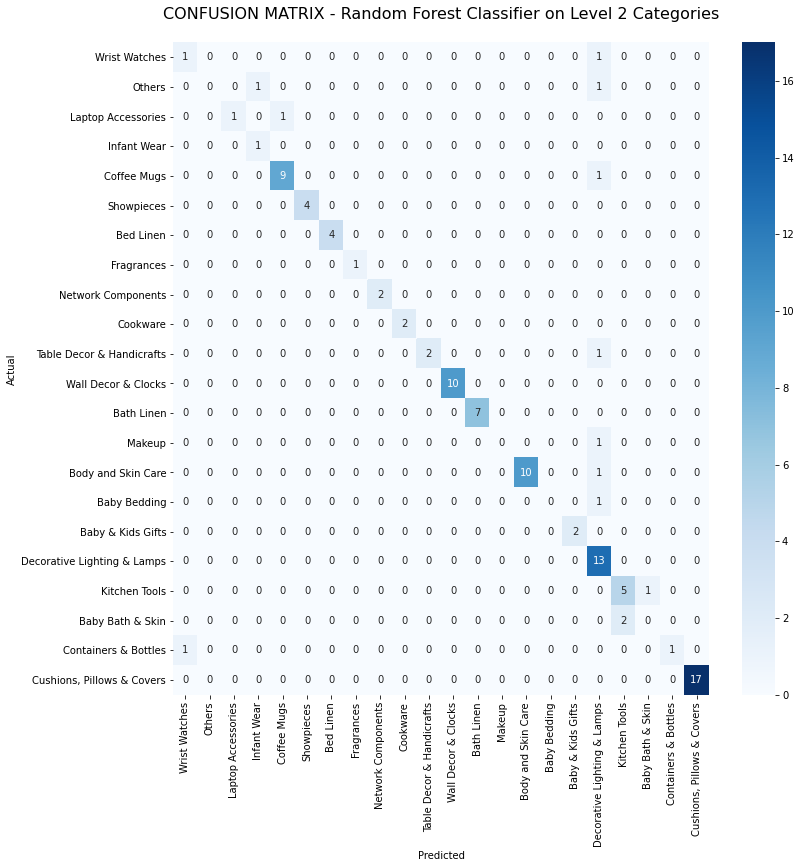

In [41]:
# We train the classifier
t0 = time()
RF_model_2 = RandomForestClassifier(max_features="sqrt")
RF_model_2.fit(X_train_2, y_train_2)

# We try to predict the test set
RF_y_pred_2 = RF_model_2.predict(X_test_2)
t1 = time()
RF_model_2_time = t1-t0

# We evaluate the accuracy of the model
RF_accuracy_2 = metrics.accuracy_score(y_test_2, RF_y_pred_2)*100
print('Our Random Forest Classifier has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RF_accuracy_2, RF_model_2_time))

# We create a confusion matrix to see where are the most problematic categories
category_label = list(dict(data_df['category 2'].value_counts()).keys())
test_list = []
test_list.extend(list(y_test_2))
test_list.extend(list(RF_y_pred_2))
for lbl in category_label:
    if lbl not in test_list:
        category_label.remove(lbl)

conf_mat = confusion_matrix(y_test_2, RF_y_pred_2)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_label, 
            yticklabels=category_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest Classifier on Level 2 Categories\n", size=16)
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix RF Level 2.png')

#### Categories of Level 3 ####

Our Random Forest Classifier has an accuracy of : 82.86% in 0.58s.


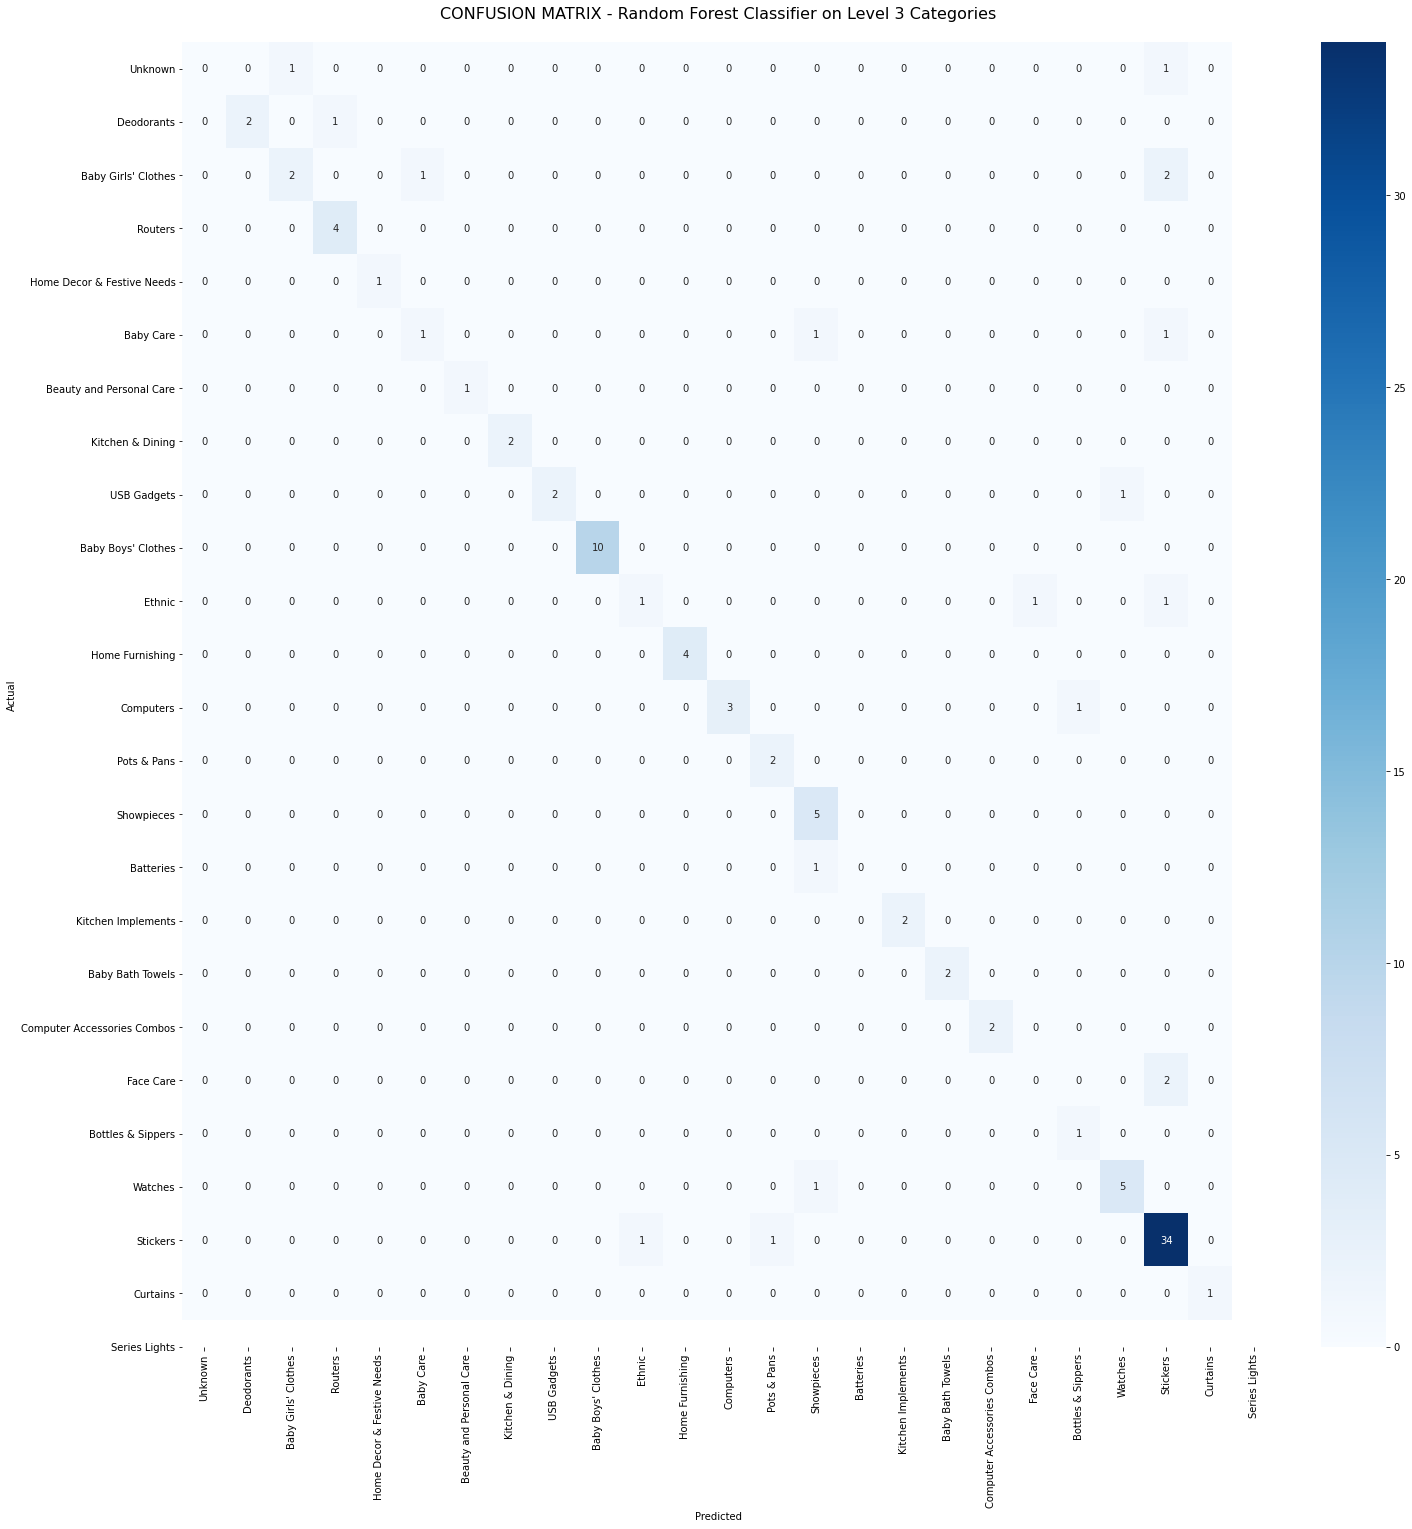

In [42]:
# We train the classifier
t0 = time()
RF_model_3 = RandomForestClassifier(max_features="sqrt")
RF_model_3.fit(X_train_3, y_train_3)

# We try to predict the test set
RF_y_pred_3 = RF_model_3.predict(X_test_3)
t1 = time()
RF_model_3_time = t1-t0

# We evaluate the accuracy of the model
RF_accuracy_3 = metrics.accuracy_score(y_test_3, RF_y_pred_3)*100
print('Our Random Forest Classifier has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RF_accuracy_3, RF_model_3_time))

# We create a confusion matrix to see where are the most problematic categories
category_label = list(dict(data_df['category 3'].value_counts()).keys())
test_list = []
test_list.extend(list(y_test_3))
test_list.extend(list(RF_y_pred_3))
for lbl in category_label:
    if lbl not in test_list:
        category_label.remove(lbl)

conf_mat = confusion_matrix(y_test_3, RF_y_pred_3)
fig, ax = plt.subplots(figsize=(24,24))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_label, 
            yticklabels=category_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Random Forest Classifier on Level 3 Categories\n", size=16)
plt.savefig('Ressources' + '/' + 'Soutenance' + '/' + 'Confusion Matrix RF Level 3.png')

Our results are even better, while the level 1 categories stay the ones with the better accuracy and time.

Again, some crossvalidation could improve the results.

### RNN ### 

Lastly, we will use a Reccurent Neural Network and see how it performs compared to the last two classifiers. 

#### Categories of Level 1 ####

In [297]:
def RNN_classifier(method_set, labels):
    # Counting labels
    category_label = set(labels)
    label_number = len(category_label)
    parameters_number = 4 *((method_set['X_train'].shape[1]+1) * label_number + label_number^2)

    # We create the RNN
    RNN_model = keras.Sequential()
    RNN_model.add(layers.Flatten())
    RNN_model.add(layers.Dense(parameters_number, activation='ReLU'))
    RNN_model.add(layers.Dense(label_number, activation='softmax'))
    RNN_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    
    # We train the RNN to classify
    t0 = time()

    epochs = 12
    batch_size = 64

    RNN_history = RNN_model.fit(method_set['X_train'], method_set['y_train_encoded'], 
                                    epochs=epochs, batch_size=batch_size,
                                    validation_split=0.1)

    # We try to predict the test set
    RNN_y_pred = RNN_model.predict(method_set['X_test'])
    t1 = time()
    RNN_model_time = t1-t0

    # We evaluate the accuracy of the model
    rounded_labels = np.argmax(method_set['y_test_encoded'], axis=1)
    rounded_pred = np.argmax(RNN_y_pred, axis=1)
    RNN_accuracy = RNN_history.history['accuracy'][-1]
    print('Our Recurrent Neural Network has an accuracy of : {:.2f}% in {:.2f}s.'
          .format(RNN_accuracy, RNN_model_time))

    # We look at the evolutions of the loss and accuracy over epoch
    show_loss_acc(RNN_history, 'RNN CBOW Level 1')

    # We look at the confusion matrix
    create_confusion_matrix(rounded_labels, rounded_pred, labels, 'RNN')

Epoch 1/12
14/14 [==============================] - 1s 15ms/step - loss: 1.5863 - accuracy: 0.4541 - val_loss: 1.2213 - val_accuracy: 0.6105
Epoch 2/12
14/14 [==============================] - 0s 5ms/step - loss: 1.0774 - accuracy: 0.6659 - val_loss: 0.9074 - val_accuracy: 0.7263
Epoch 3/12
14/14 [==============================] - 0s 6ms/step - loss: 0.8183 - accuracy: 0.7541 - val_loss: 0.7376 - val_accuracy: 0.7579
Epoch 4/12
14/14 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.8035 - val_loss: 0.6840 - val_accuracy: 0.7474
Epoch 5/12
14/14 [==============================] - 0s 5ms/step - loss: 0.5932 - accuracy: 0.8188 - val_loss: 0.5702 - val_accuracy: 0.7789
Epoch 6/12
14/14 [==============================] - 0s 4ms/step - loss: 0.5390 - accuracy: 0.8329 - val_loss: 0.5135 - val_accuracy: 0.8316
Epoch 7/12
14/14 [==============================] - 0s 5ms/step - loss: 0.4792 - accuracy: 0.8682 - val_loss: 0.4532 - val_accuracy: 0.8421
Epoch 8/12
14/14 [=

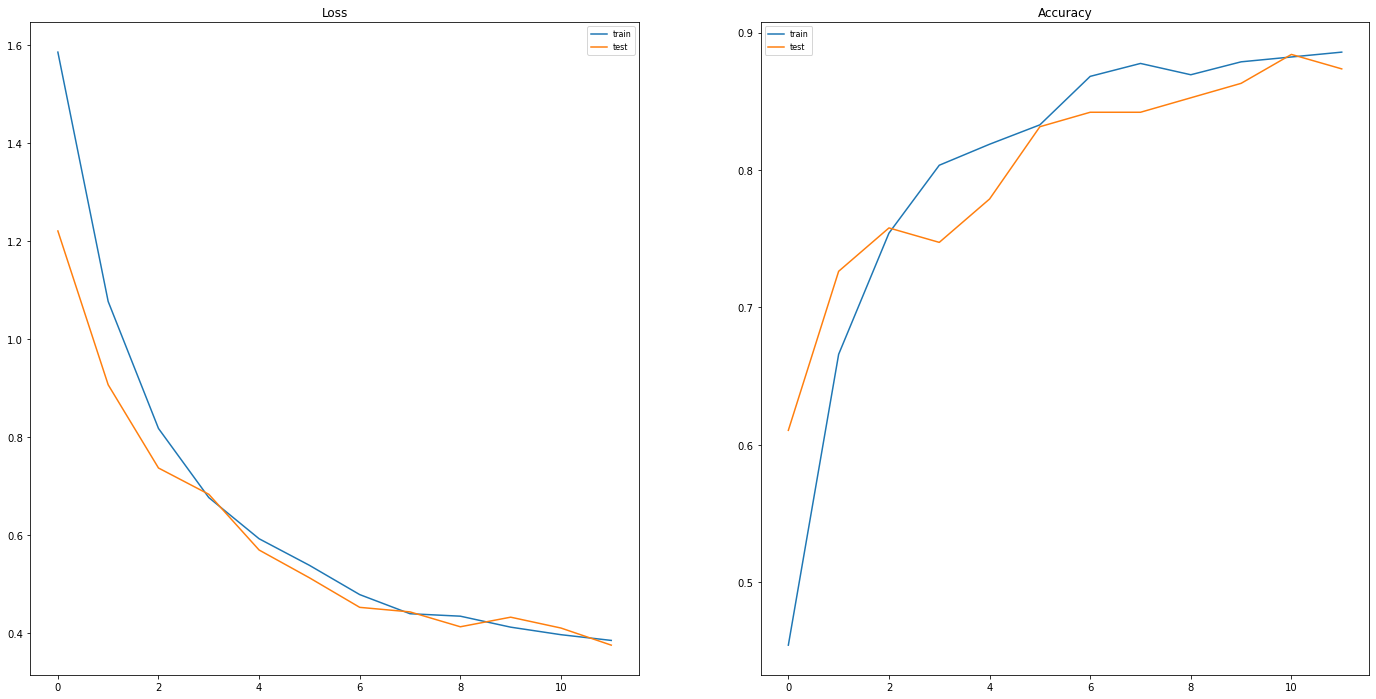

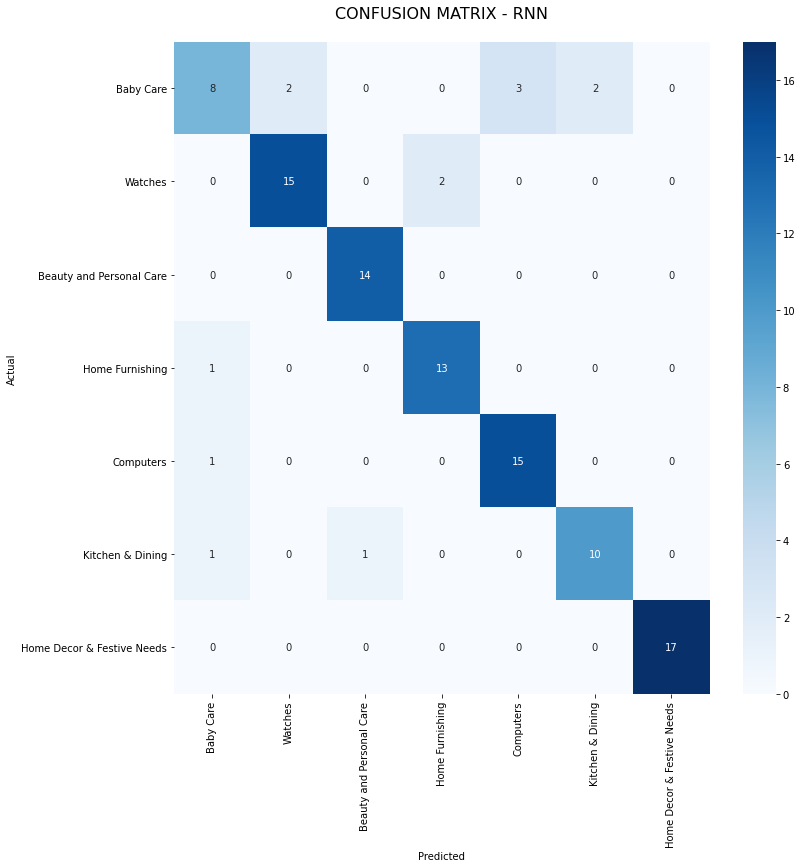

In [298]:
RNN_classifier(SkipGram_set_1, labels_1)

In [171]:
# Counting labels
category_label = list(dict(data_df['category 1'].value_counts()).keys())
label_number = len(category_label)
parameters_number = 4 *((CBOW_X_train_1.shape[1]+1) * label_number + label_number^2)

# We create the RNN
RNN_model_1 = keras.Sequential()
RNN_model_1.add(layers.Flatten())
RNN_model_1.add(layers.Dense(parameters_number, activation='ReLU'))
RNN_model_1.add(layers.Dense(label_number, activation='softmax'))
RNN_model_1.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Epoch 1/12
14/14 [==============================] - 0s 9ms/step - loss: 0.9838 - accuracy: 0.6247 - val_loss: 0.9618 - val_accuracy: 0.7053
0.6247059106826782
Epoch 2/12
14/14 [==============================] - 0s 5ms/step - loss: 0.9693 - accuracy: 0.6612 - val_loss: 1.0117 - val_accuracy: 0.5895
0.6611764430999756
Epoch 3/12
14/14 [==============================] - 0s 6ms/step - loss: 0.9495 - accuracy: 0.6671 - val_loss: 0.9850 - val_accuracy: 0.6105
0.6670588254928589
Epoch 4/12
14/14 [==============================] - 0s 6ms/step - loss: 0.9384 - accuracy: 0.6471 - val_loss: 0.9561 - val_accuracy: 0.6842
0.6470588445663452
Epoch 5/12
14/14 [==============================] - 0s 5ms/step - loss: 0.9075 - accuracy: 0.6882 - val_loss: 0.9506 - val_accuracy: 0.6526
0.6882352828979492
Epoch 6/12
14/14 [==============================] - 0s 5ms/step - loss: 0.8810 - accuracy: 0.6941 - val_loss: 0.9310 - val_accuracy: 0.6632
0.6941176652908325
Epoch 7/12
14/14 [============================

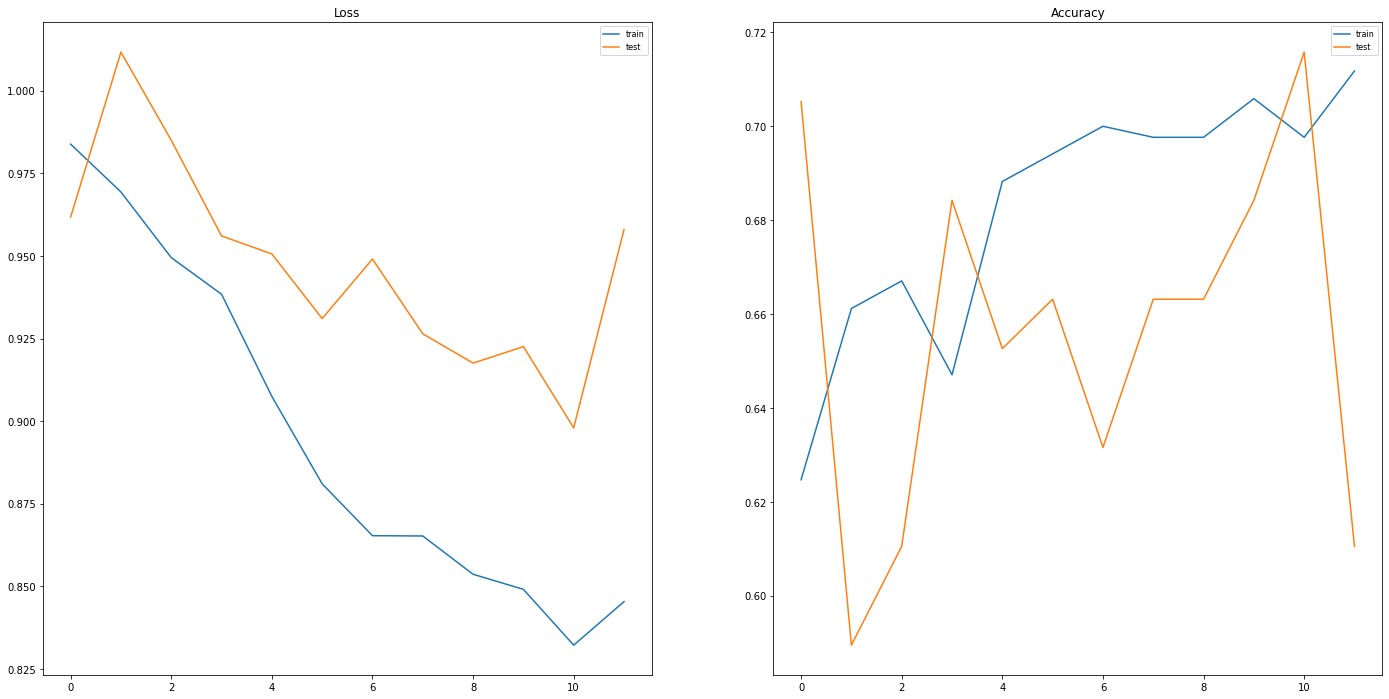

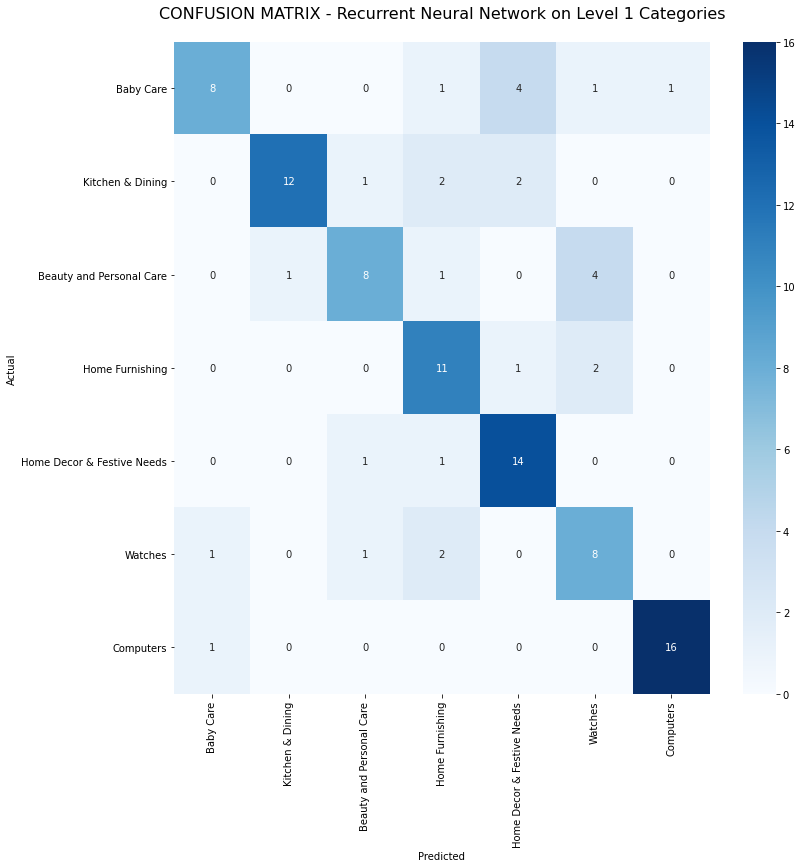

In [175]:
# We train the RNN to classify
t0 = time()

epochs = 12
batch_size = 64

RNN_history_1 = RNN_model_1.fit(CBOW_X_train_1, CBOW_y_train_1_encoded, 
                                epochs=epochs, batch_size=batch_size,
                                validation_split=0.1)

# We try to predict the test set
RNN_y_pred_1 = RNN_model_1.predict(CBOW_X_test_1)
t1 = time()
RNN_model_1_time = t1-t0

# We evaluate the accuracy of the model
rounded_labels_1 = np.argmax(CBOW_y_test_1_encoded, axis=1)
rounded_pred_1 = np.argmax(RNN_y_pred_1, axis=1)
RNN_accuracy_1 = RNN_history_1.history['accuracy'][-1]
print('Our Recurrent Neural Network has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RNN_accuracy_1, RNN_model_1_time))

# We look at the evolutions of the loss and accuracy over epoch
show_loss_acc(RNN_history_1, 'RNN CBOW Level 1')

# We look at the confusion matrix
create_confusion_matrix(rounded_labels_1, rounded_pred_1, category_label, 1)

#### Categories of Level 2 ####

In [144]:
# Counting labels
category_label = list(dict(data_df['category 2'].value_counts()).keys())
label_number = len(category_label)
parameters_number = 4 *((CBOW_X_train_2.shape[1]+1) * label_number + label_number^2)

# We create the RNN
RNN_model_2 = keras.Sequential()
RNN_model_2.add(layers.Flatten())
RNN_model_2.add(layers.Dense(parameters_number, activation='ReLU'))
RNN_model_2.add(layers.Dense(label_number, activation='softmax'))
RNN_model_2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Epoch 1/12
14/14 [==============================] - 0s 12ms/step - loss: 0.2905 - accuracy: 0.9024 - val_loss: 2.0905 - val_accuracy: 0.7368
Epoch 2/12
14/14 [==============================] - 0s 12ms/step - loss: 0.3003 - accuracy: 0.9035 - val_loss: 2.0534 - val_accuracy: 0.7053
Epoch 3/12
14/14 [==============================] - 0s 11ms/step - loss: 0.2703 - accuracy: 0.9212 - val_loss: 2.1412 - val_accuracy: 0.7158
Epoch 4/12
14/14 [==============================] - 0s 12ms/step - loss: 0.3092 - accuracy: 0.8941 - val_loss: 2.1993 - val_accuracy: 0.6947
Epoch 5/12
14/14 [==============================] - 0s 13ms/step - loss: 0.2989 - accuracy: 0.9024 - val_loss: 2.0480 - val_accuracy: 0.7158
Epoch 6/12
14/14 [==============================] - 0s 13ms/step - loss: 0.2815 - accuracy: 0.9106 - val_loss: 2.1053 - val_accuracy: 0.7158
Epoch 7/12
14/14 [==============================] - 0s 11ms/step - loss: 0.2647 - accuracy: 0.9094 - val_loss: 2.0434 - val_accuracy: 0.7053
Epoch 8/12
14

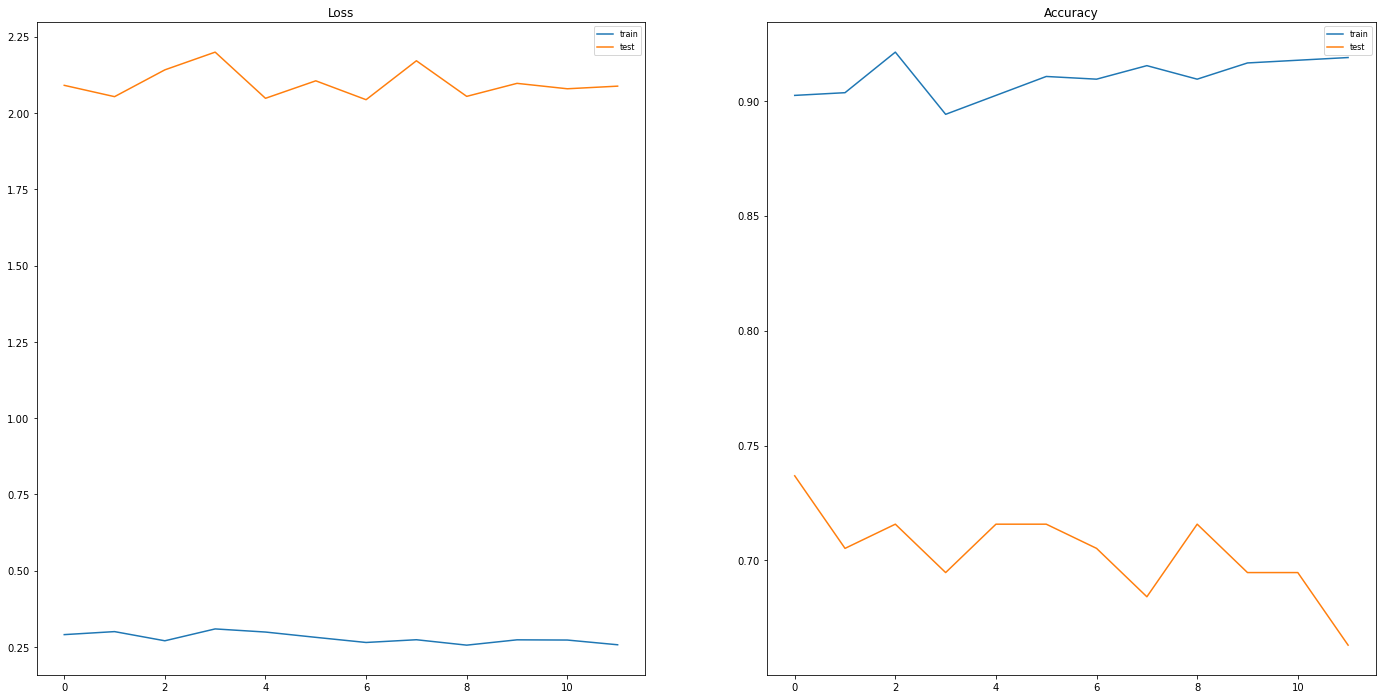

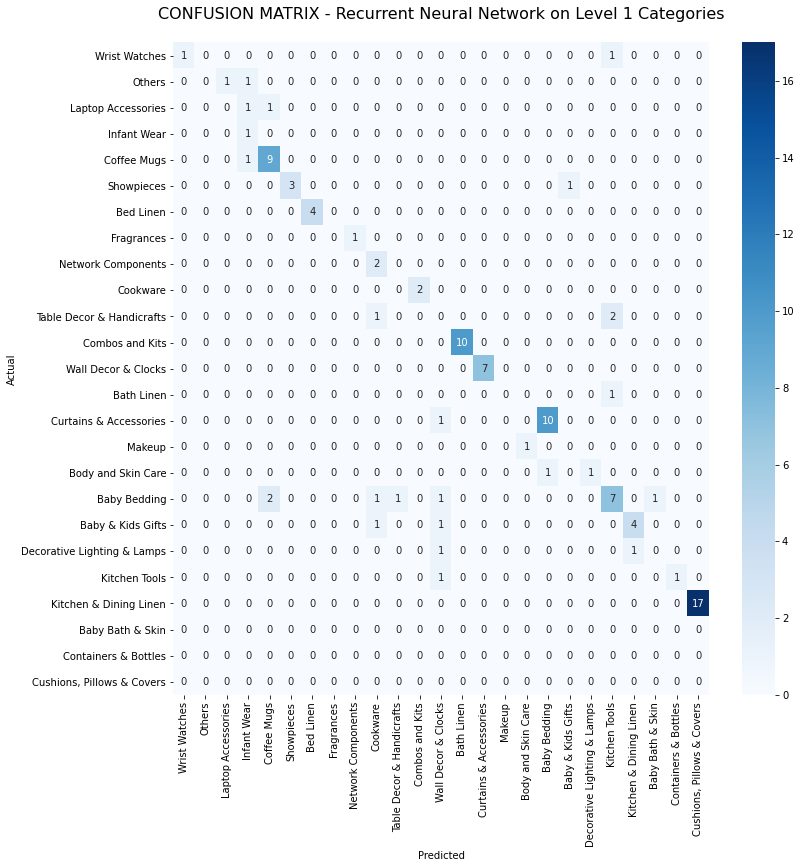

In [159]:
# We train the RNN to classify
t0 = time()

epochs = 12
batch_size = 64

RNN_history_2 = RNN_model_2.fit(CBOW_X_train_2, CBOW_y_train_2_encoded,
                                epochs=epochs, batch_size=batch_size,
                                validation_split=0.1)

# We try to predict the test set
RNN_y_pred_2 = RNN_model_2.predict(CBOW_X_test_2)
t1 = time()
RNN_model_2_time = t1-t0

# We evaluate the accuracy of the model
rounded_labels_2 = np.argmax(CBOW_y_test_2_encoded, axis=1)
rounded_pred_2 = np.argmax(RNN_y_pred_2, axis=1)
RNN_accuracy_2 = RNN_history_2.history['accuracy'][-1]
print('Our Recurrent Neural Network has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RNN_accuracy_2, RNN_model_2_time))

# We look at the evolutions of the loss and accuracy over epoch
show_loss_acc(RNN_history_2, 'RNN CBOW Level 2')

# We look at the confusion matrix
create_confusion_matrix(rounded_labels_2, rounded_pred_2, category_label, 2)

#### Categories of Level 3 ####

In [164]:
# Counting labels
category_label = list(dict(data_df['category 3'].value_counts()).keys())
label_number = len(category_label)
parameters_number = 4 *((CBOW_X_train_3.shape[1]+1) * label_number + label_number^2)

# We create the RNN
RNN_model_3 = keras.Sequential()
RNN_model_3.add(layers.Flatten())
RNN_model_3.add(layers.Dense(parameters_number, activation='ReLU'))
RNN_model_3.add(layers.Dense(label_number, activation='softmax'))
RNN_model_3.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Epoch 1/12
14/14 [==============================] - 0s 15ms/step - loss: 0.4338 - accuracy: 0.8482 - val_loss: 2.0709 - val_accuracy: 0.6632
Epoch 2/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4490 - accuracy: 0.8341 - val_loss: 2.1138 - val_accuracy: 0.6526
Epoch 3/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4604 - accuracy: 0.8365 - val_loss: 2.0428 - val_accuracy: 0.6947
Epoch 4/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4459 - accuracy: 0.8400 - val_loss: 2.0987 - val_accuracy: 0.6316
Epoch 5/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4648 - accuracy: 0.8341 - val_loss: 2.1592 - val_accuracy: 0.6526
Epoch 6/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4807 - accuracy: 0.8294 - val_loss: 2.0914 - val_accuracy: 0.6316
Epoch 7/12
14/14 [==============================] - 0s 12ms/step - loss: 0.4544 - accuracy: 0.8471 - val_loss: 2.0770 - val_accuracy: 0.7053
Epoch 8/12
14

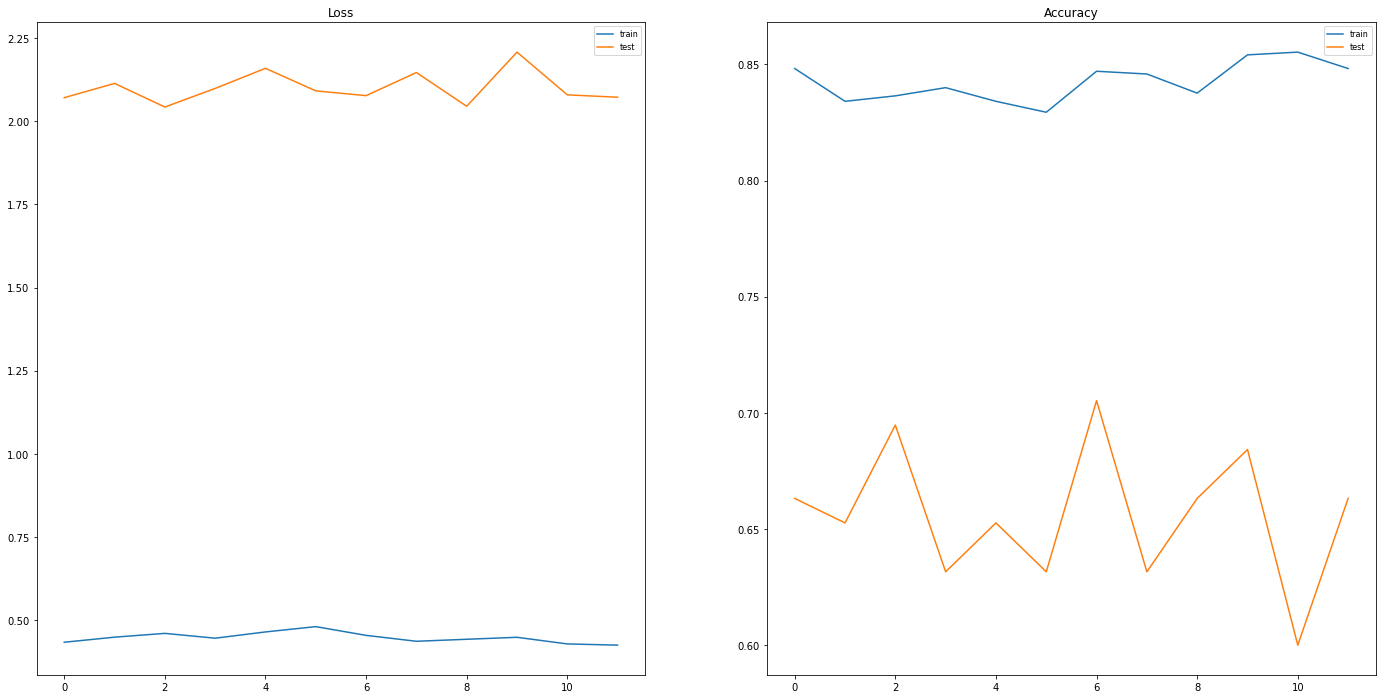

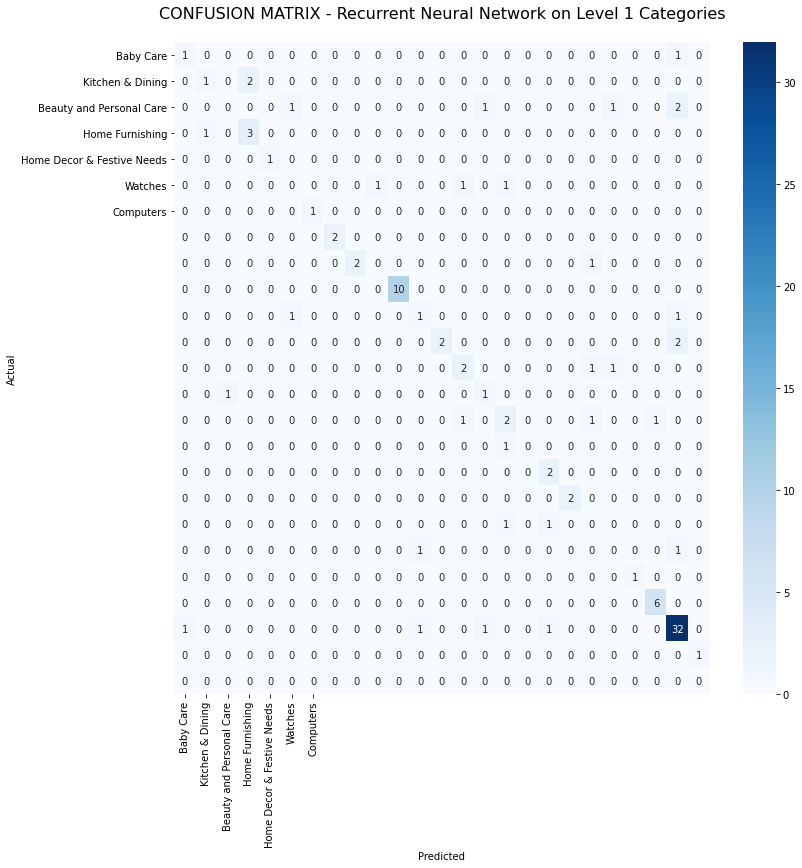

In [176]:
# We train the RNN to classify
t0 = time()

epochs = 12
batch_size = 64

RNN_history_3 = RNN_model_3.fit(CBOW_X_train_3, CBOW_y_train_3_encoded,
                                epochs=epochs, batch_size=batch_size,
                                validation_split=0.1)

# We try to predict the test set
RNN_y_pred_3 = RNN_model_3.predict(CBOW_X_test_3)
t1 = time()
RNN_model_3_time = t1-t0

# We evaluate the accuracy of the model
rounded_labels_3 = np.argmax(CBOW_y_test_3_encoded, axis=1)
rounded_pred_3 = np.argmax(RNN_y_pred_3, axis=1)
RNN_accuracy_3 = RNN_history_3.history['accuracy'][-1]*100
print('Our Recurrent Neural Network has an accuracy of : {:.2f}% in {:.2f}s.'
      .format(RNN_accuracy_3, RNN_model_3_time))

# We look at the evolutions of the loss and accuracy over epoch
show_loss_acc(RNN_history_3, 'RNN CBOW Level 3')

# We look at the confusion matrix
create_confusion_matrix(rounded_labels_3, rounded_pred_3, category_label, 3)

## Conclusion on the text data ##

# Image Data #

## Pre Treatment ## 

As for the text data, we will have to go through several pretreatments before being able to use the information contained in the data.

### Exposition ###

To be sure that our pictures look the best, we will look at its histogram and stretch it.

### Contrast ###

We will start by adjusting the contrast of the images. 

### Noise ###

We will now try to suppress the potential noise.

#### Median Filter ####

We will first use a median filter to delete the 'salt and pepper' type of noise. 

#### Gaussian Filter ####

We will now use a gaussian filter to get rid of the most typical background noise.

## Feature Extraction ##

We have to extract the features of the different images to be able to compare and classify them.

### Create Descriptors ### 

Thanks to the SIFT method, we will create descriptors of the images. 

### Cluster Descriptors ###

We will now cluster the descriptors thanks to a MiniBatch K-Means machine learning unsupervised method.

### Histogram per image ###

We will see for a few images how the descriptor clusters work. 

### Dimension Reduction ###

We will reduce the dimension of our descriptors to speed and ease up the classification.

### Visualisation ###

Thanks to a t-SNE, we will visualize the different image categories we have. 

### Similarities between cluster category ###

We will verify if the categories found match the categories we had.

## CNN ##

We will now look and compare how a Convolutionnal Neural Network performs.